In [1]:
# Imports
import math
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from data import Data
from params import params

In [2]:
# Initalize dataset objects

gtzan = False
dataset_path = './ljspeech_train_valid'
train_list = './filelists/ljs_audio_text_train_v3.txt'
valid_list = './filelists/ljs_audio_text_val.txt'

# Output signature for datasets.
signature = (
	tf.TensorSpec(shape=(None,), dtype=tf.float32),		# audio
	tf.TensorSpec(
		shape=(None, params.n_mels), dtype=tf.float32
	)													# mel
)
if params.unconditional:
	# Output signature is different if using unconditional model.
	signature = (
		tf.TensorSpec(shape=(None,), dtype=tf.float32),	# audio
		tf.TensorSpec(shape=(), dtype=tf.float32)		# mel
	)
if gtzan:
	# Output signature is different if using gtzan.
	signature = (
		tf.TensorSpec(shape=(1, None,), dtype=tf.float32),	# audio
		tf.TensorSpec(shape=(), dtype=tf.float32)			# mel
	)

train_data = Data(
	dataset_path, # dataset_path
	train_list, # filelist_path
	params,
	# n_mel_channels=n_mel_channels,
	n_mel_channels=params.n_mels,
	# n_speakers=params.n_spks,
	n_speakers=1, # Manually added because this tests LJSpeech dataset
	load_mel_from_disk=False,
	# sampling_rate=sampling_rate,
	sampling_rate=params.sample_rate,
	# filter_length=filter_length,
	filter_length=params.n_fft,
	hop_length=params.hop_length,
	win_length=params.win_length,
	# mel_fmin=mel_fmin,
	# mel_fmax=mel_fmax
	mel_fmin=params.f_min,
	mel_fmax=params.f_max, 
	from_gtzan=gtzan
)

valid_data = Data(
	dataset_path, # dataset_path
	valid_list, # filelist_path
	params,
	# n_mel_channels=n_mel_channels,
	n_mel_channels=params.n_mels,
	# n_speakers=params.n_spks,
	n_speakers=1, # Manually added because this tests LJSpeech dataset
	load_mel_from_disk=False,
	# sampling_rate=sampling_rate,
	sampling_rate=params.sample_rate,
	# filter_length=filter_length,
	filter_length=params.n_fft,
	hop_length=params.hop_length,
	win_length=params.win_length,
	# mel_fmin=mel_fmin,
	# mel_fmax=mel_fmax
	mel_fmin=params.f_min,
	mel_fmax=params.f_max, 
	from_gtzan=gtzan
)

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-07-21 10:10:27.315982: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-21 10:10:27.316846: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
# Load training dataset with generator

train_dataset = tf.data.Dataset.from_generator( # Use in eager execution.
	train_data.generator,
	args=(),
	output_signature=signature
)

train_dataset = train_dataset.batch(params.batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [3]:
# Load training dataset with generator

valid_dataset = tf.data.Dataset.from_generator( # Use in eager execution.
	valid_data.generator,
	args=(),
	output_signature=signature
)

valid_dataset = valid_dataset.batch(params.batch_size, drop_remainder=True)
valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)

In [4]:
# Sample the audio from the (validation) dataset (one batch)

audio, mel_spec = list(valid_dataset.take(1).as_numpy_iterator())[0]
print(f'audio (batch) shape {audio.shape}')
print(f'mel spectrogram (batch) shape {mel_spec.shape}')
print()
print(f'audio tensor: {audio}')
print(f'mel spectrogram tensor: {mel_spec}')
print()
print(f'audio tensor max & min: {tf.math.reduce_max(audio)}, {tf.math.reduce_min(audio)}')
print(f'mel spectrogram tensor max & min: {tf.math.reduce_max(mel_spec)}, {tf.math.reduce_min(mel_spec)}')

2023-07-21 10:10:34.869141: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
 11%|█         | 11/100 [00:00<00:07, 12.54it/s]


audio (batch) shape (4, 15872)
mel spectrogram (batch) shape (4, 62, 80)

audio tensor: [[-3.1738281e-03 -6.3781738e-03 -8.4533691e-03 ... -1.1901855e-03
  -1.1901855e-03 -1.4038086e-03]
 [ 8.5449219e-04  3.9672852e-04 -9.1552734e-04 ...  9.2468262e-03
   3.4179688e-03 -2.7160645e-03]
 [ 6.1035156e-05  1.5258789e-04 -6.1035156e-05 ...  1.1047363e-02
  -6.8359375e-03 -1.5411377e-02]
 [ 2.1972656e-02  2.3406982e-02  2.4322510e-02 ...  1.0131836e-02
   1.2847900e-02  1.1566162e-02]]
mel spectrogram tensor: [[[-2.6022131e+00 -1.2554871e+00 -1.4235196e+00 ... -7.9857506e-02
    2.8074162e-02  1.6066743e-02]
  [-2.2795320e+00 -1.2486185e+00 -9.9627048e-01 ...  6.2689614e-01
    9.9799538e-01  6.6643631e-01]
  [-1.6481613e+00 -1.6621536e+00 -1.1762465e+00 ...  1.0551068e+00
    1.3900335e+00  1.0144150e+00]
  ...
  [-2.7529833e+00 -2.0148580e+00 -1.8123642e+00 ... -8.9975089e-01
   -8.0735660e-01 -7.1317840e-01]
  [-3.3257260e+00 -2.1227870e+00 -1.7005651e+00 ... -8.8182425e-01
   -7.6128513e

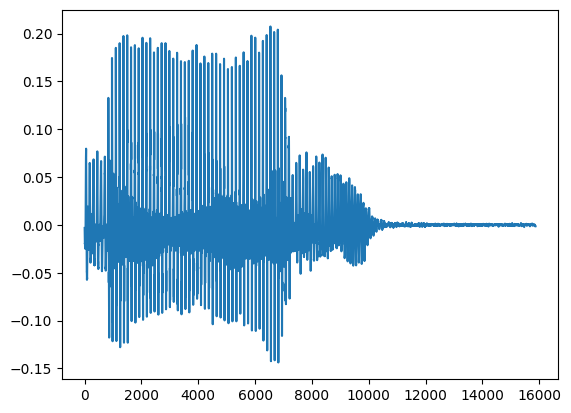

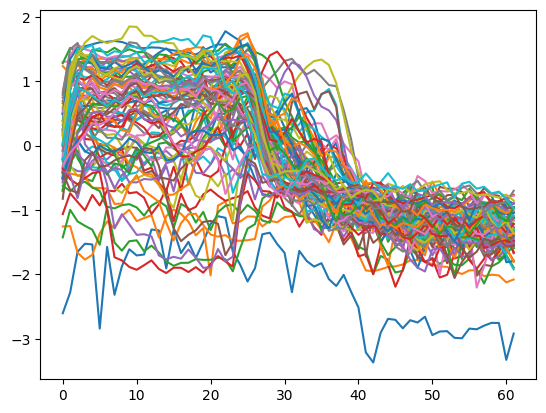

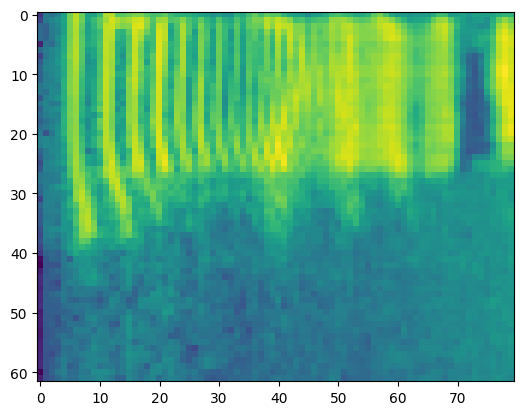

In [5]:
# Chart the audio and spectrogram samples

import matplotlib.pyplot as plt

plt.figure()
plt.plot(audio[0])

plt.figure()
plt.plot(mel_spec[0])

plt.figure()
plt.imshow(mel_spec[0])

In [6]:
# Noising steps.

N, T = audio.shape

# Noise.
print(f'noise schedule: {params.noise_schedule}')

beta = np.array(params.noise_schedule)
print(f'beta: {beta}\n')

noise_level = np.cumprod(1 - beta)
noise_level = tf.convert_to_tensor(noise_level)
print(f'noise_level {noise_level}\n')

t = tf.random.uniform([N], 0, len(params.noise_schedule))
t = tf.cast(tf.round(t), dtype=tf.int32)
print(f't {t}\n')

# noise_scale = tf.expand_dims(noise_level[t], 1)
noise_scale = tf.expand_dims(tf.gather(noise_level, t), 1)
noise_scale = tf.cast(noise_scale, dtype=tf.float32) # added to convert from float64 to float32
print(f'noise_scale {noise_scale}\n')

noise_scale_sqrt = noise_scale ** 0.5
print(f'noise_scale_sqrt {noise_scale_sqrt}\n')

noise = tf.random.normal(tf.shape(audio), dtype=tf.float32)
print(f'noise {noise}\n')

noisy_audio = noise_scale_sqrt * audio + (1.0 - noise_scale) ** 0.5 * noise
print(f'noisy_audio {noisy_audio}\n')

noise schedule: [0.0001, 0.0011183673469387756, 0.002136734693877551, 0.0031551020408163264, 0.004173469387755102, 0.005191836734693878, 0.006210204081632653, 0.007228571428571429, 0.008246938775510203, 0.009265306122448979, 0.010283673469387754, 0.01130204081632653, 0.012320408163265305, 0.013338775510204081, 0.014357142857142857, 0.015375510204081632, 0.016393877551020408, 0.017412244897959183, 0.01843061224489796, 0.019448979591836734, 0.02046734693877551, 0.021485714285714285, 0.02250408163265306, 0.023522448979591836, 0.02454081632653061, 0.025559183673469387, 0.026577551020408163, 0.027595918367346938, 0.028614285714285714, 0.02963265306122449, 0.030651020408163265, 0.031669387755102044, 0.03268775510204082, 0.033706122448979595, 0.03472448979591837, 0.035742857142857146, 0.03676122448979592, 0.0377795918367347, 0.03879795918367347, 0.03981632653061225, 0.04083469387755102, 0.0418530612244898, 0.042871428571428574, 0.04388979591836735, 0.044908163265306125, 0.0459265306122449, 0.

Timestep 1

noise_scale [0.9999]

noise_scale_sqrt [0.99994993]

noise [-1.3544159   0.7045493   0.03666191 ...  0.8045158  -1.2205484
  0.84755534]

noisy_audio [-0.01671895  0.00066822 -0.0080863  ...  0.0068557  -0.01339662
  0.00707252]

audio_sample [-0.00317383 -0.00637817 -0.00845337 ... -0.00119019 -0.00119019
 -0.00140381]

------------------------------------------------------------------------
Timestep 2

noise_scale [0.99878174]

noise_scale_sqrt [0.9993906]

noise [-1.3544159   0.7045493   0.03666191 ...  0.8045158  -1.2205484
  0.84755534]

noisy_audio [-0.05044585  0.018217   -0.00716859 ...  0.02689101 -0.04379096
  0.02817975]

audio_sample [-0.00317383 -0.00637817 -0.00845337 ... -0.00119019 -0.00119019
 -0.00140381]

------------------------------------------------------------------------
Timestep 3

noise_scale [0.9966476]

noise_scale_sqrt [0.99832237]

noise [-1.3544159   0.7045493   0.03666191 ...  0.8045158  -1.2205484
  0.84755534]

noisy_audio [-0.0815891   0.

/var/folders/n3/nm4mpct53gg_p7d3n3k7z2nw0000gn/T/ipykernel_23941/4135200312.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Timestep 12

noise_scale [0.9336226]

noise_scale_sqrt [0.9662415]

noise [-1.3544159   0.7045493   0.03666191 ...  0.8045158  -1.2205484
  0.84755534]

noisy_audio [-0.35201582  0.1753559   0.00127751 ...  0.2061239  -0.31560978
  0.21700612]

audio_sample [-0.00317383 -0.00637817 -0.00845337 ... -0.00119019 -0.00119019
 -0.00140381]

------------------------------------------------------------------------
Timestep 13

noise_scale [0.92212]

noise_scale_sqrt [0.96027076]

noise [-1.3544159   0.7045493   0.03666191 ...  0.8045158  -1.2205484
  0.84755534]

noisy_audio [-0.38102445  0.19049373  0.00211371 ...  0.22337323 -0.3417612
  0.23517916]

audio_sample [-0.00317383 -0.00637817 -0.00845337 ... -0.00119019 -0.00119019
 -0.00140381]

------------------------------------------------------------------------
Timestep 14

noise_scale [0.90982]

noise_scale_sqrt [0.9538448]

noise [-1.3544159   0.7045493   0.03666191 ...  0.8045158  -1.2205484
  0.84755534]

noisy_audio [-0.40975815  0.2

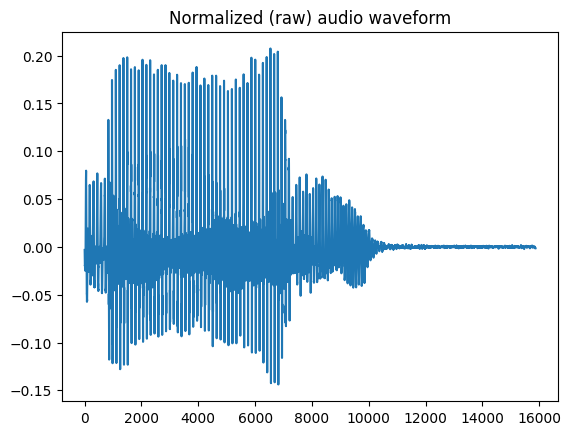

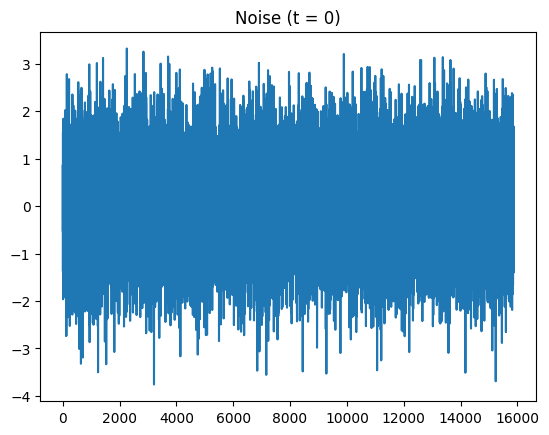

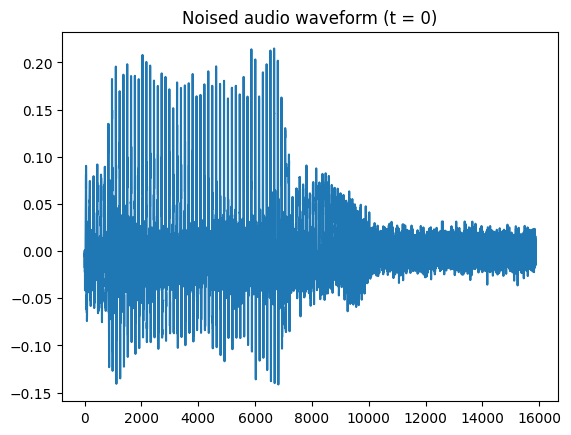

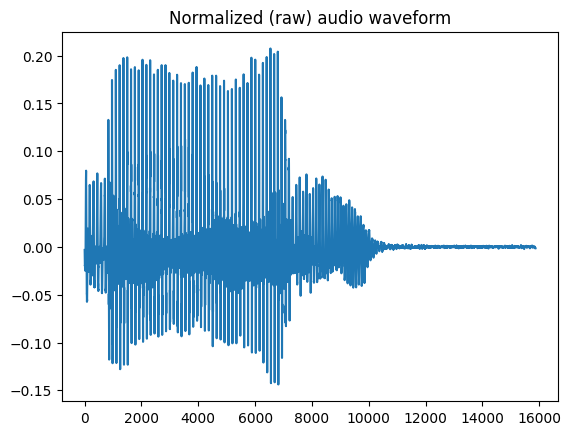

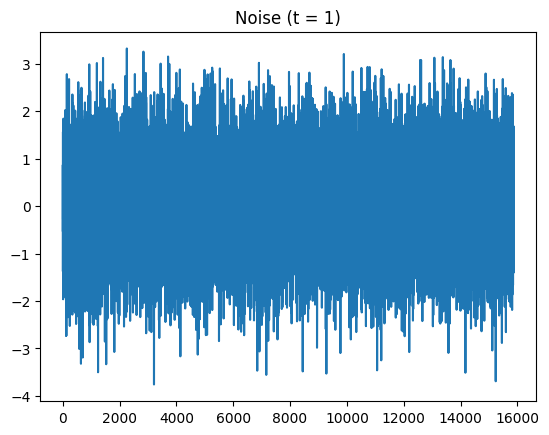

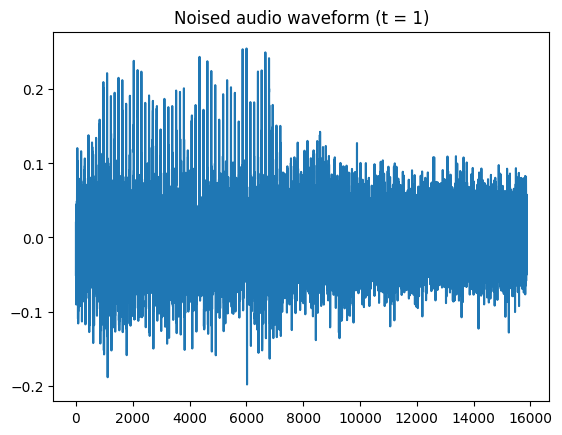

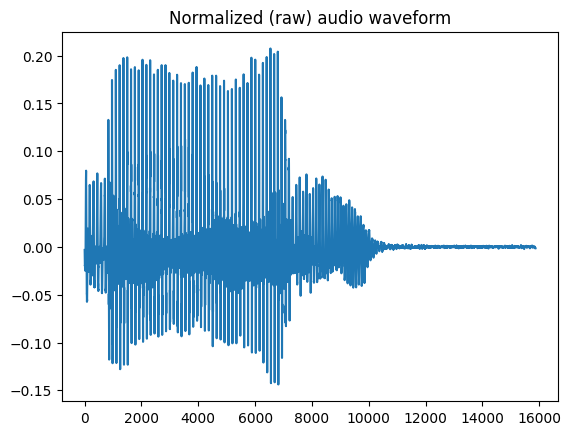

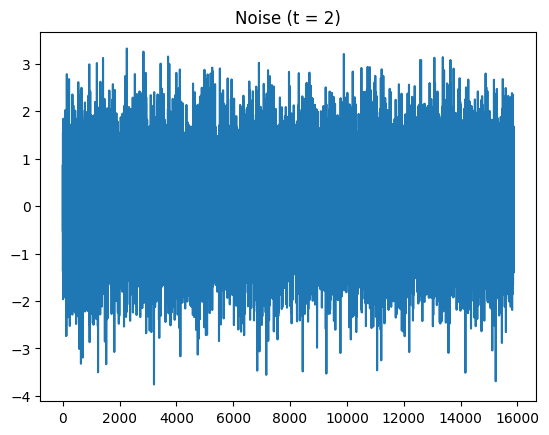

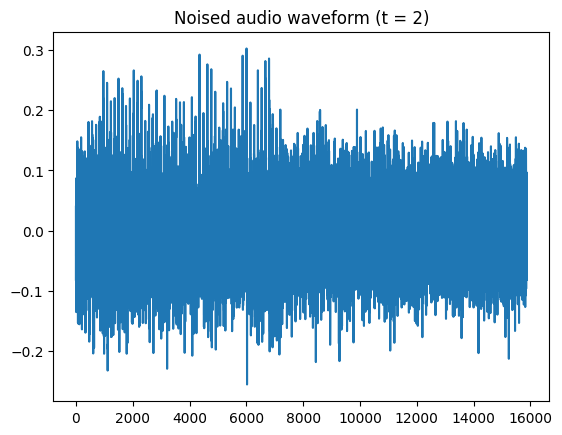

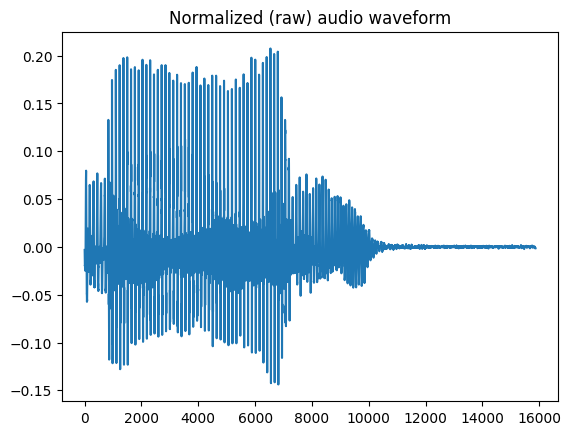

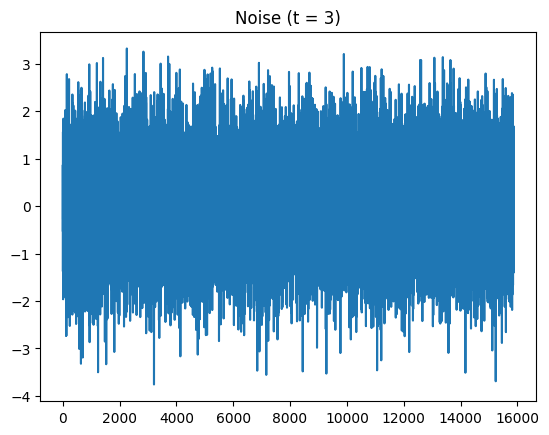

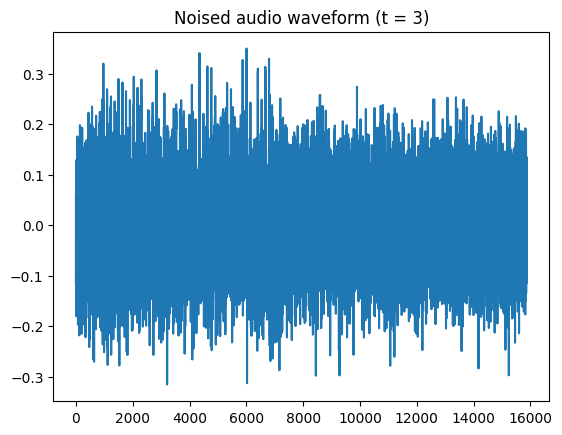

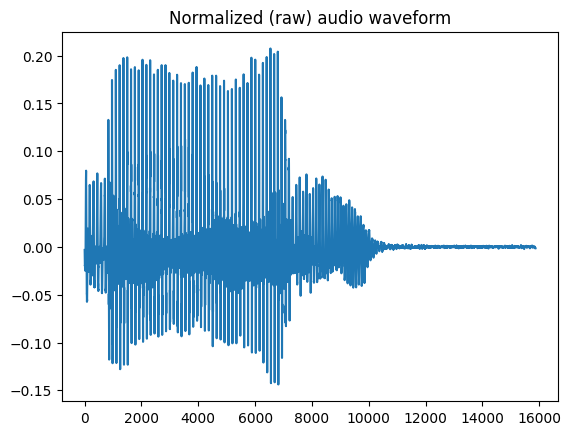

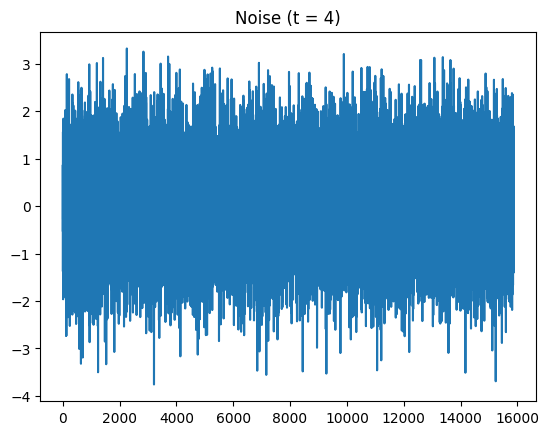

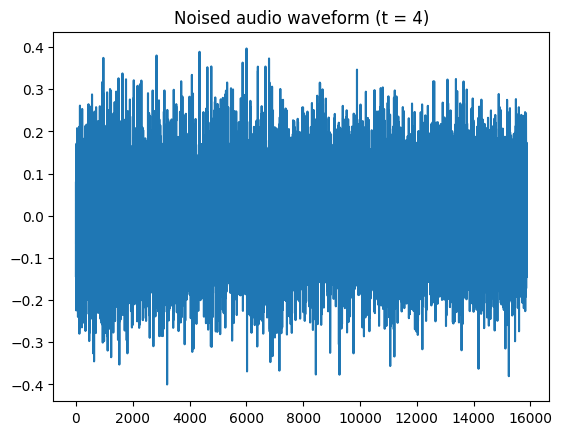

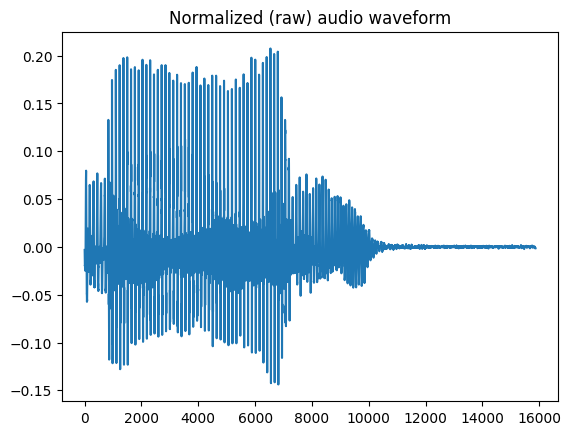

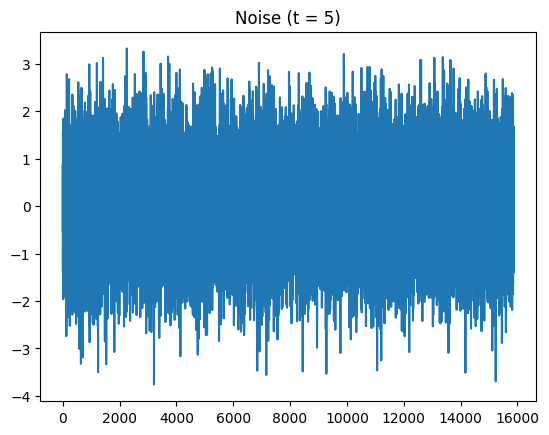

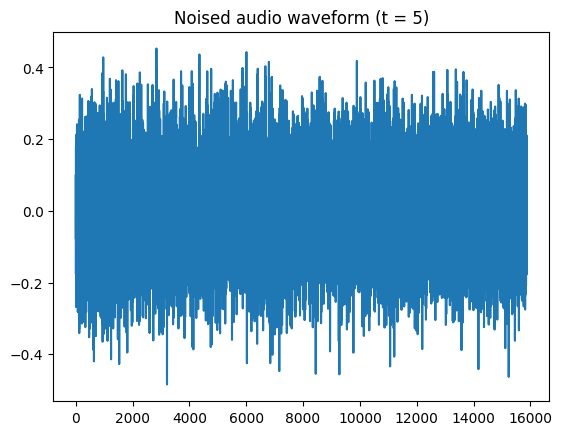

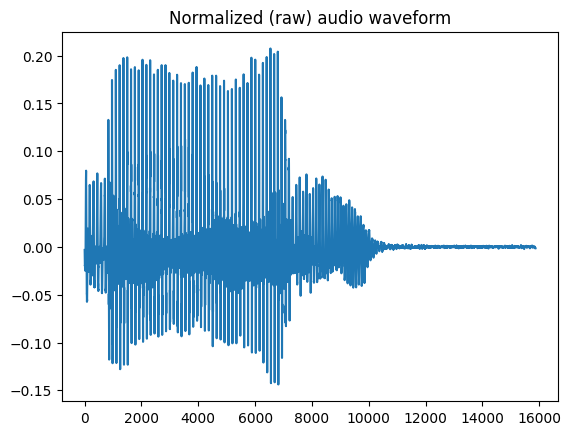

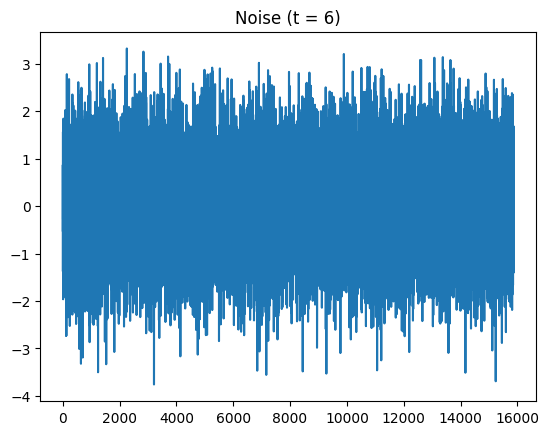

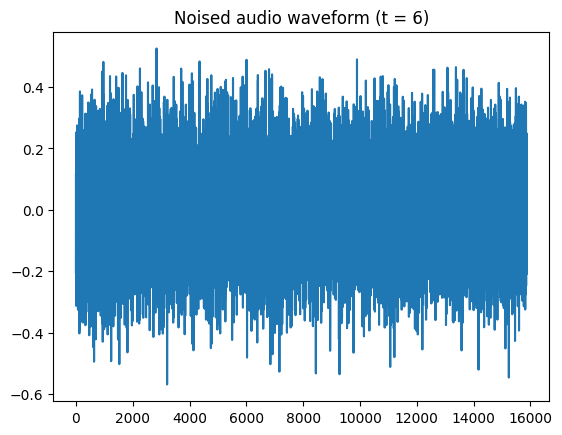

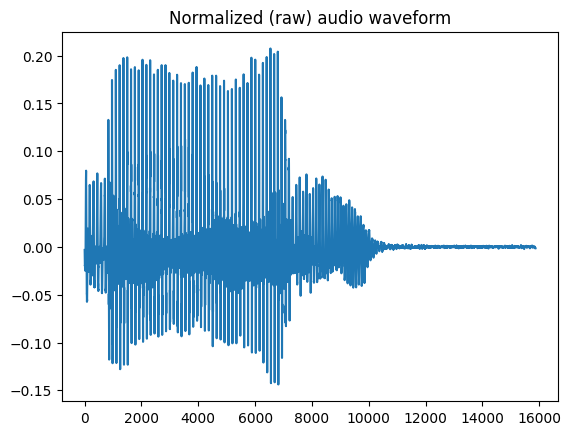

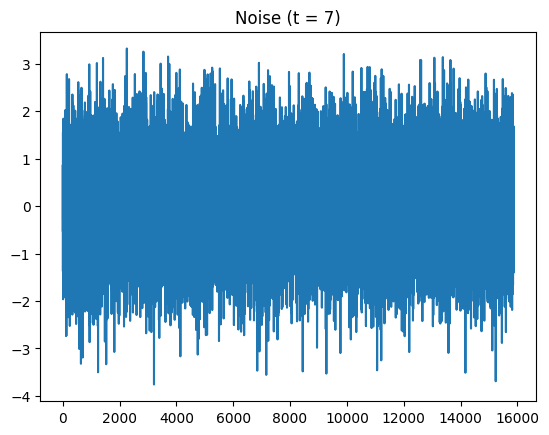

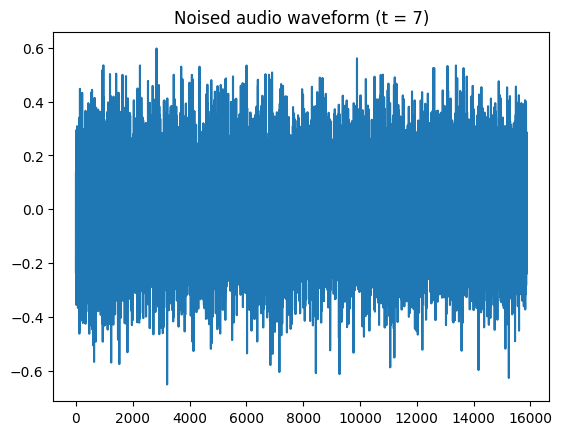

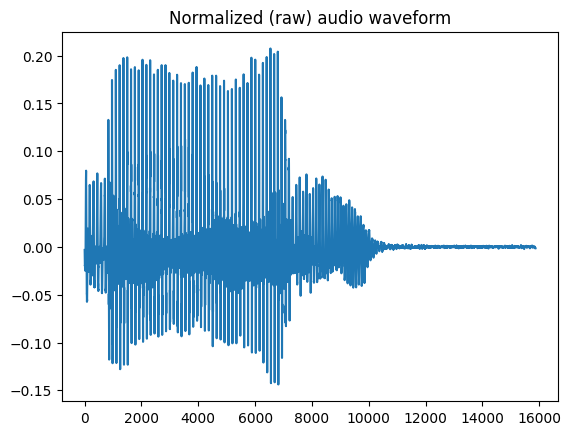

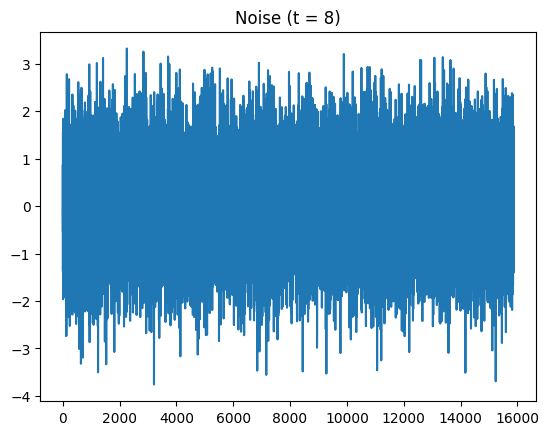

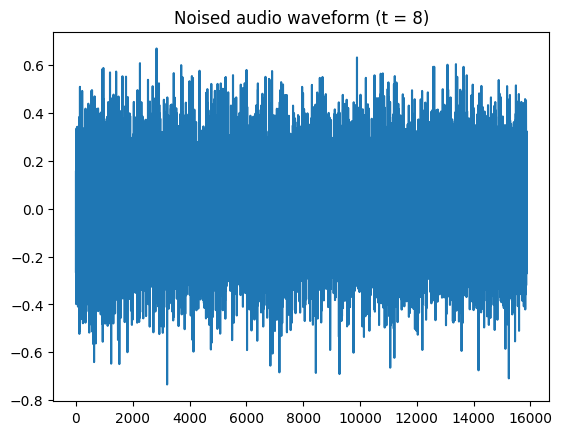

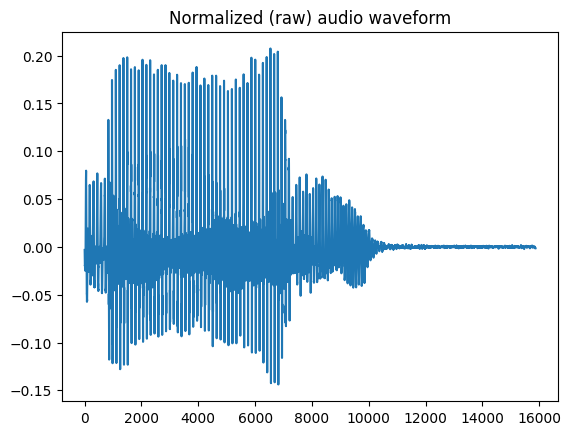

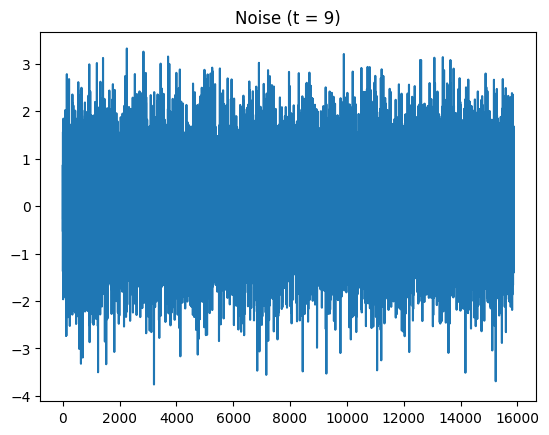

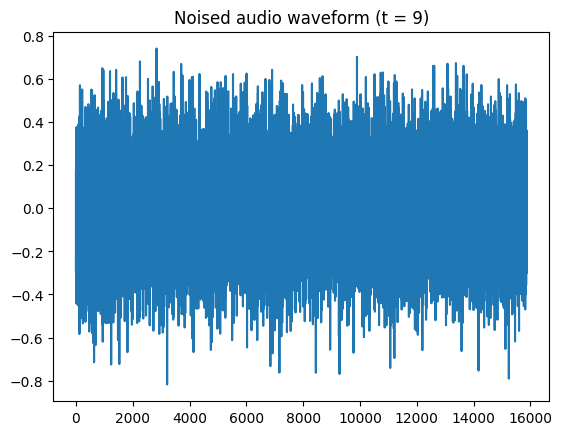

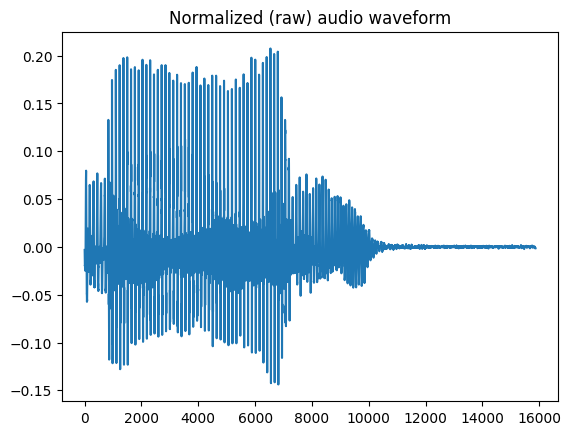

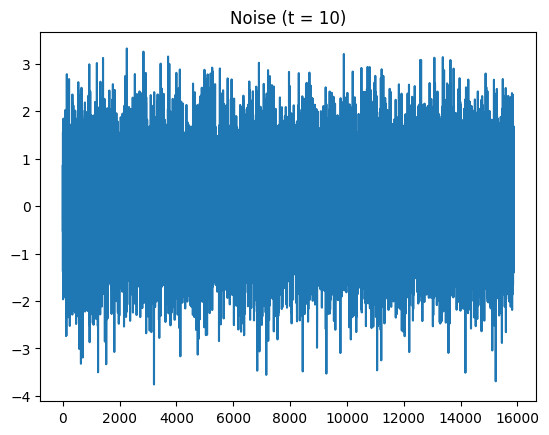

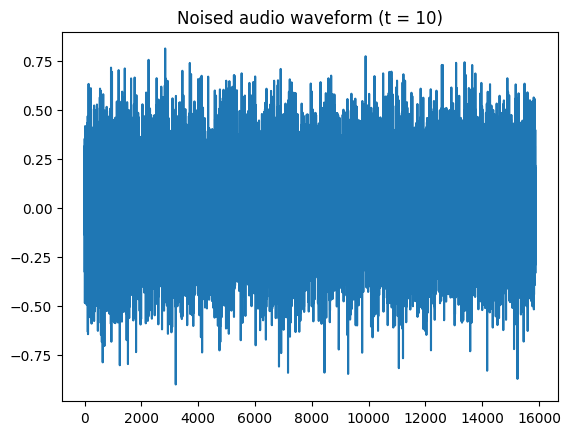

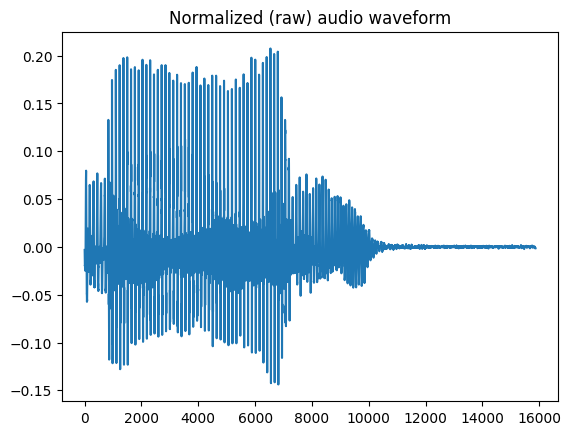

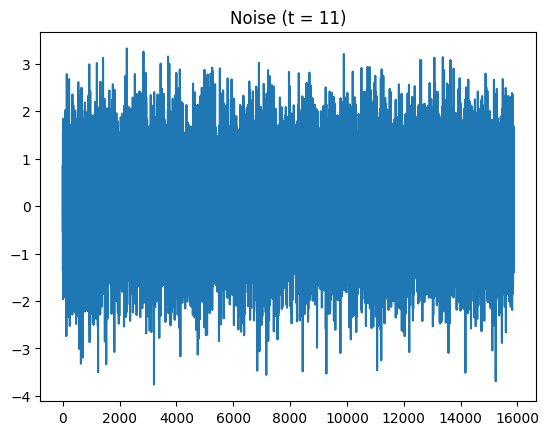

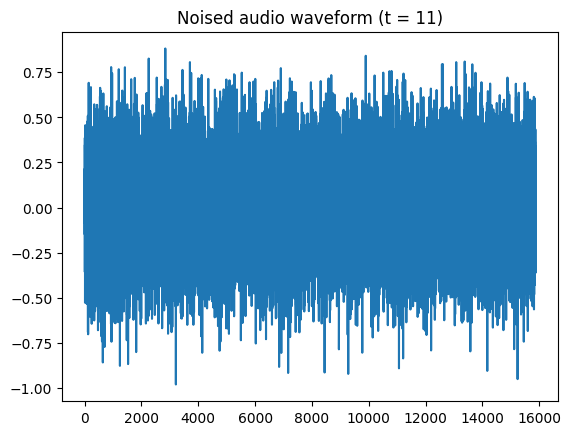

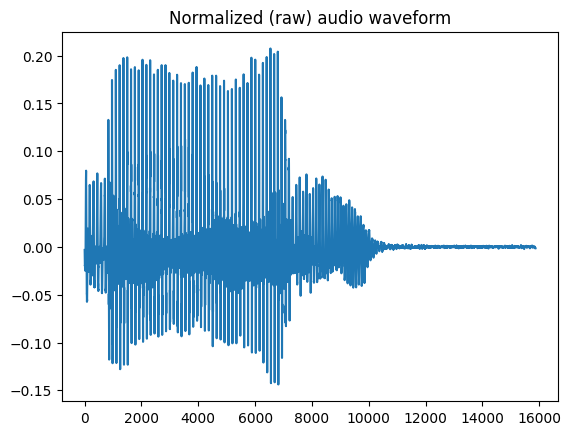

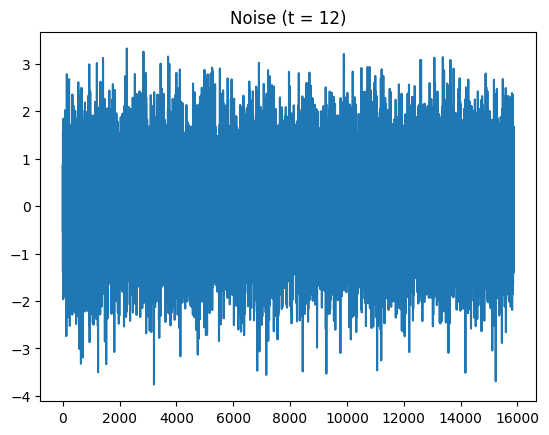

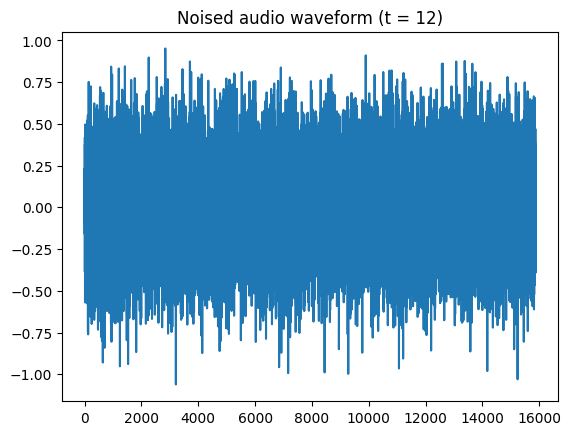

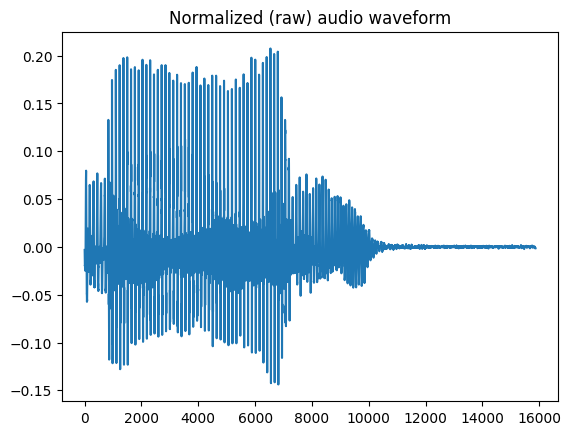

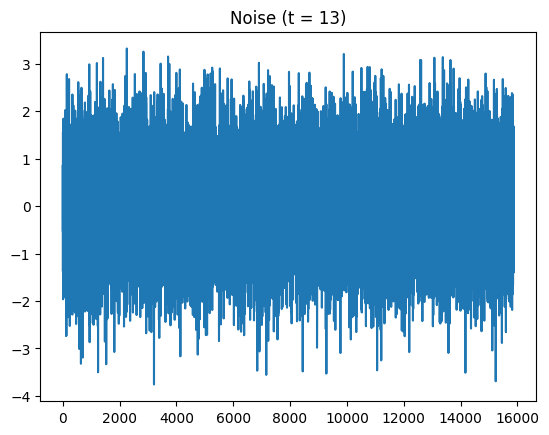

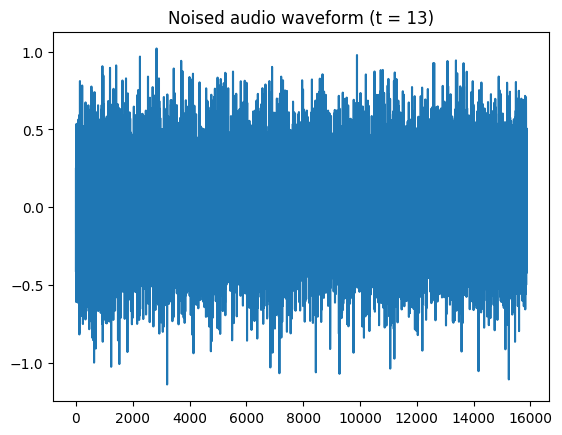

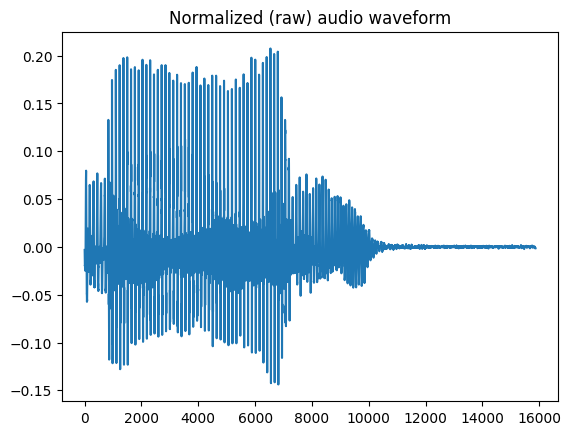

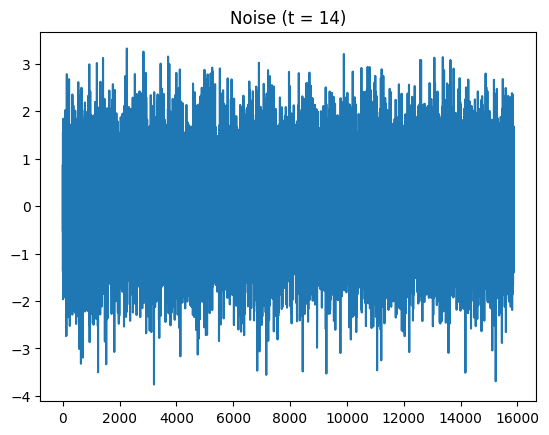

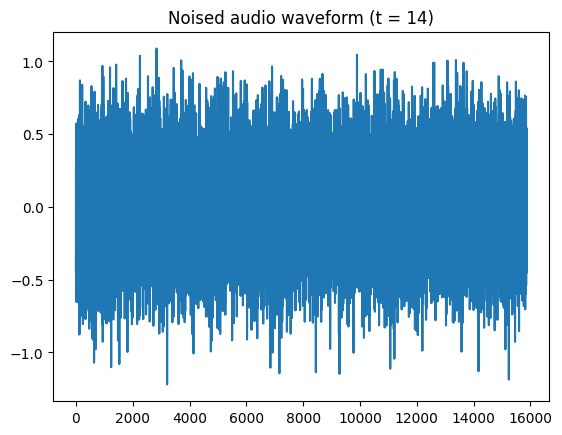

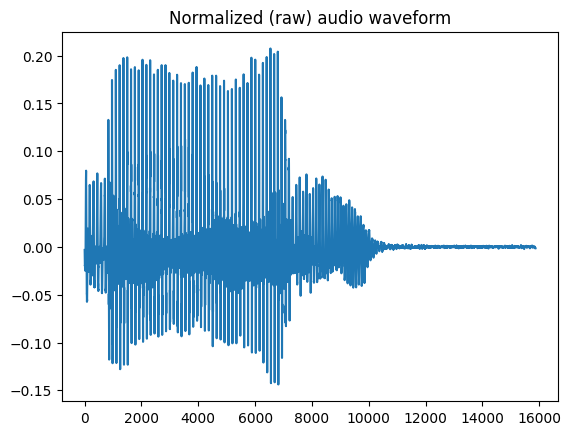

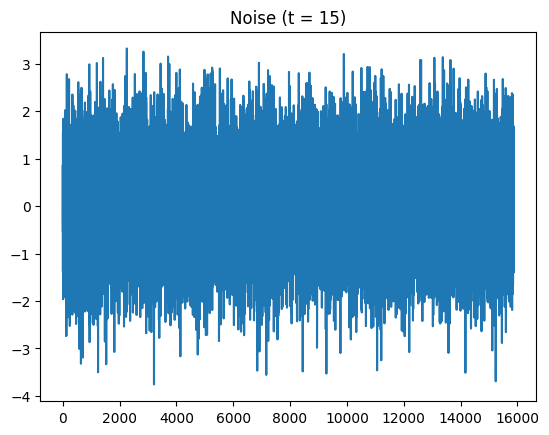

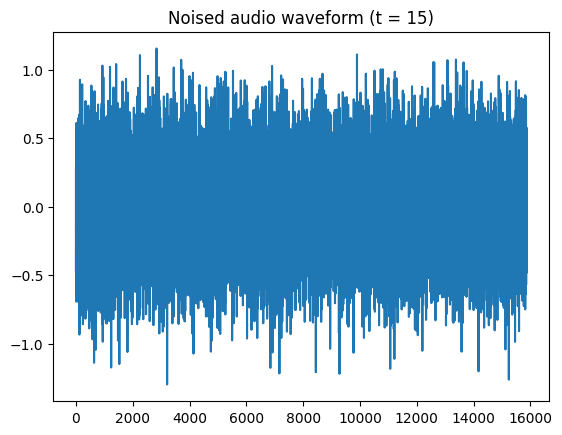

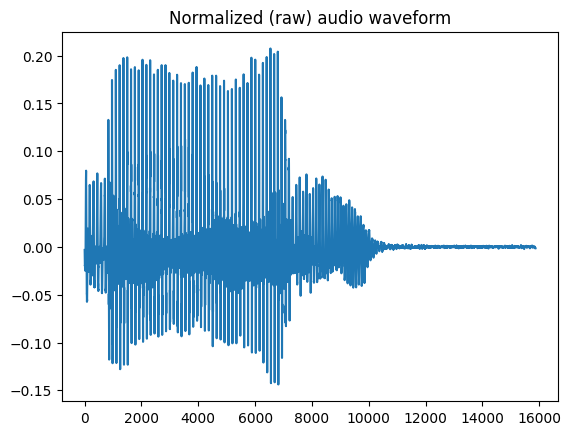

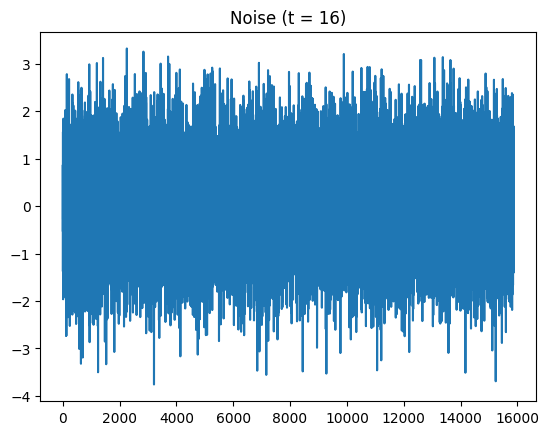

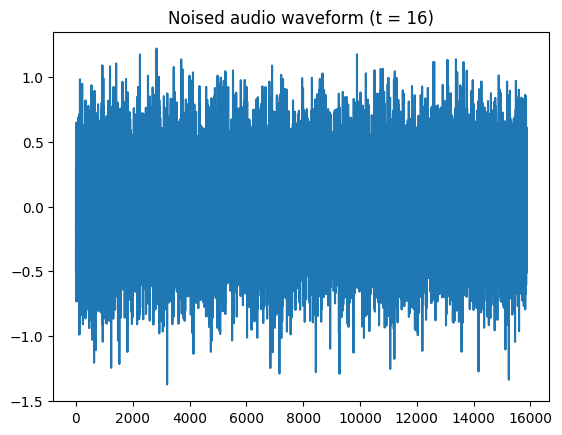

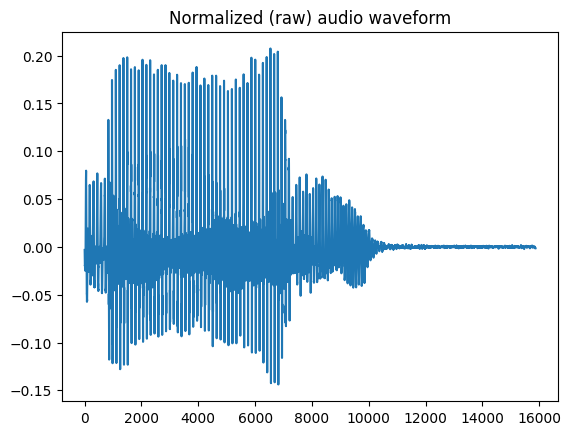

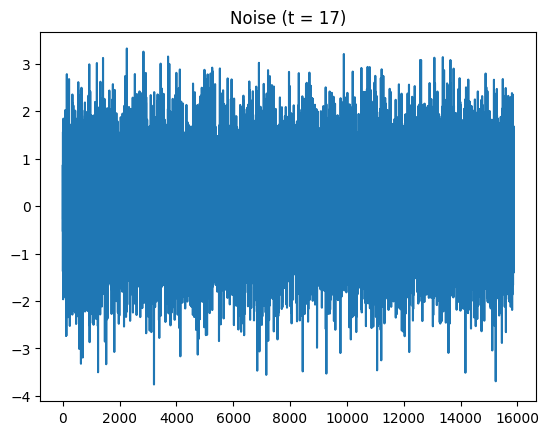

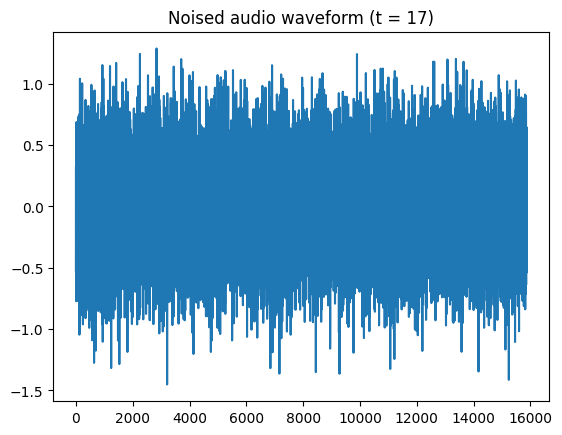

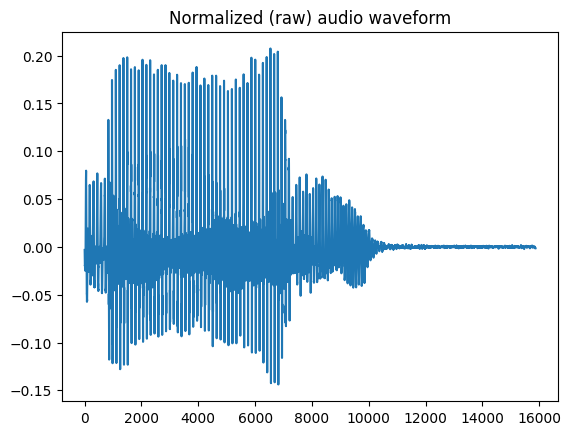

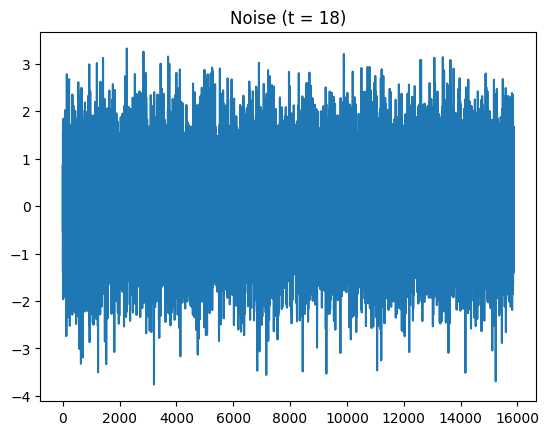

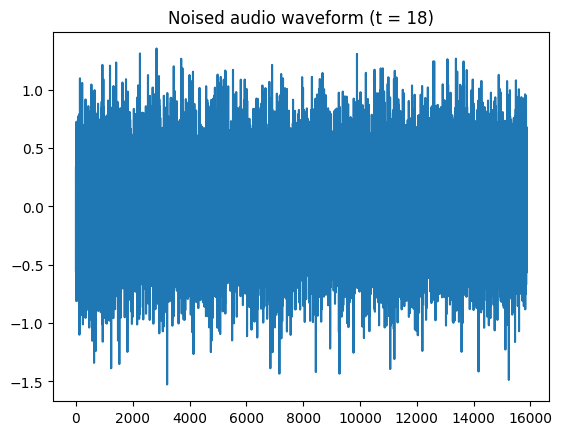

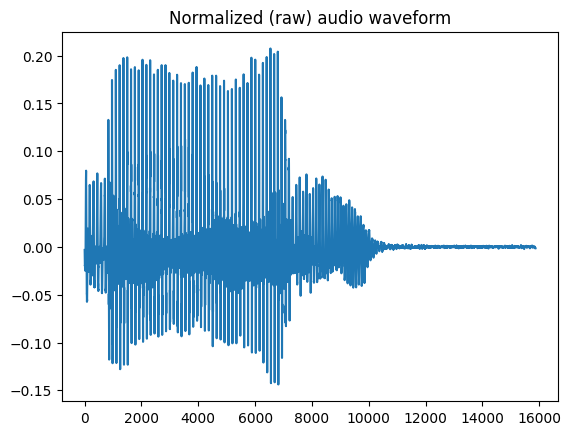

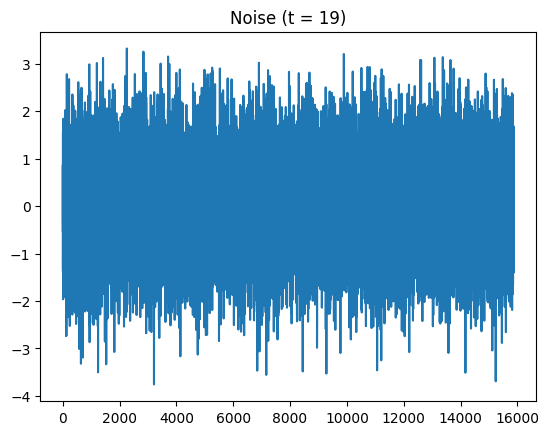

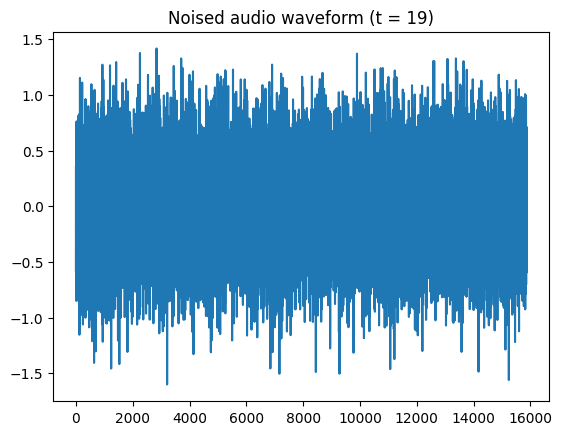

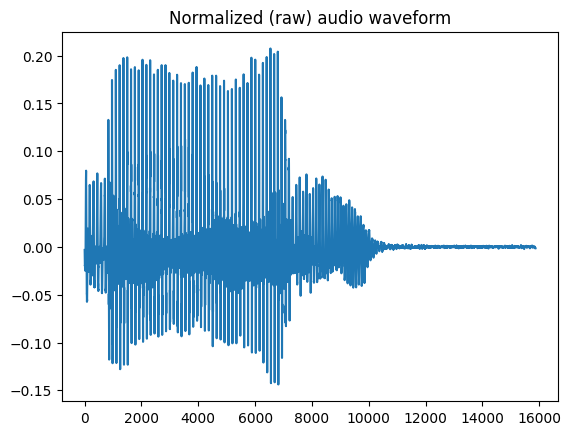

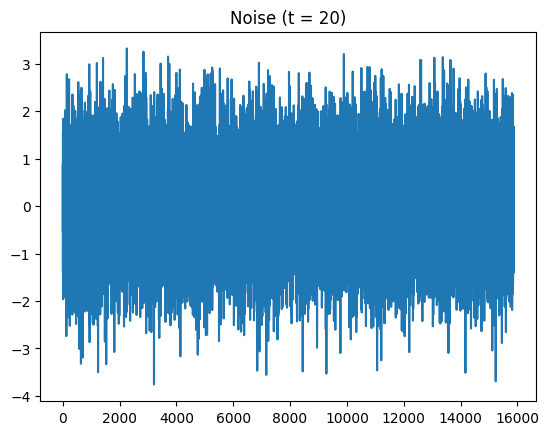

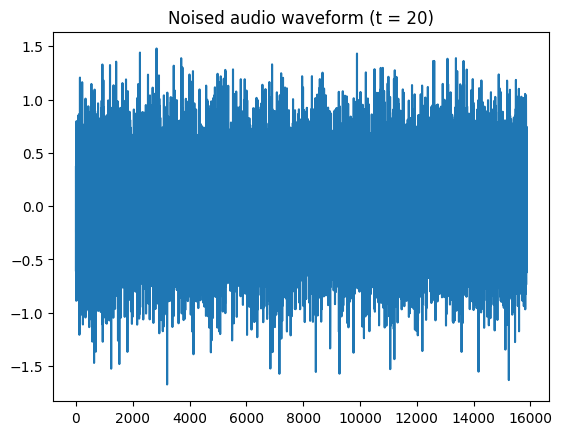

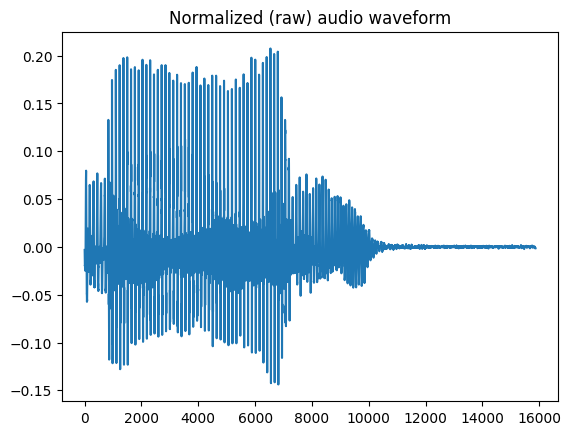

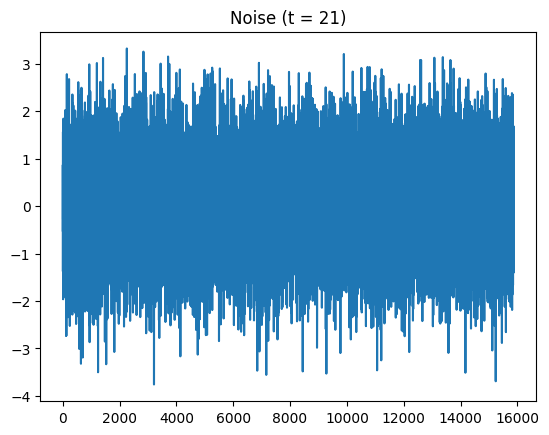

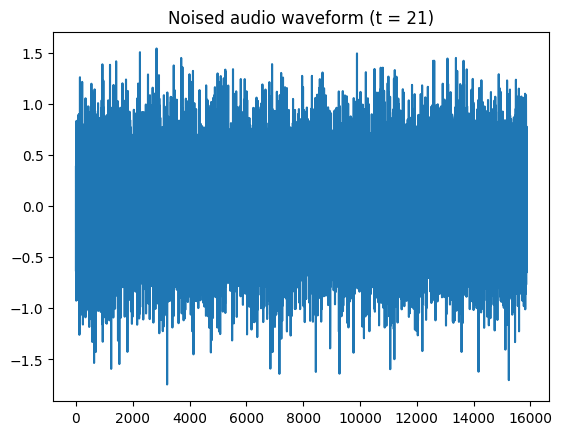

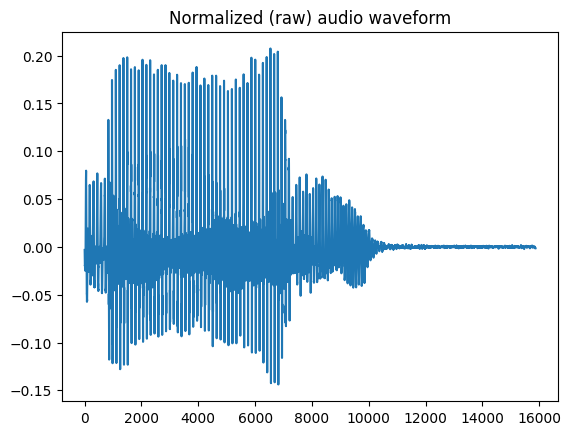

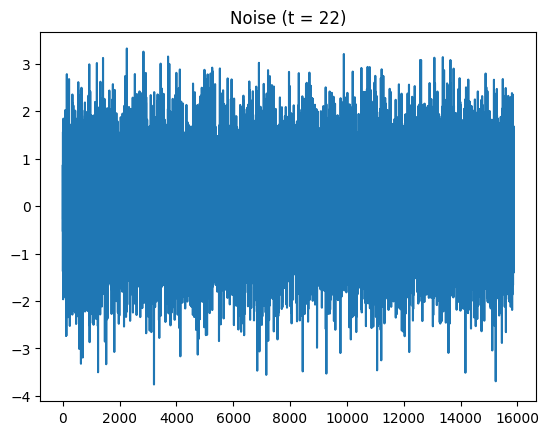

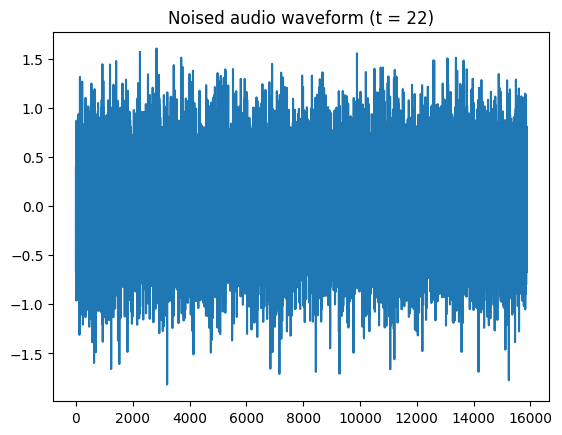

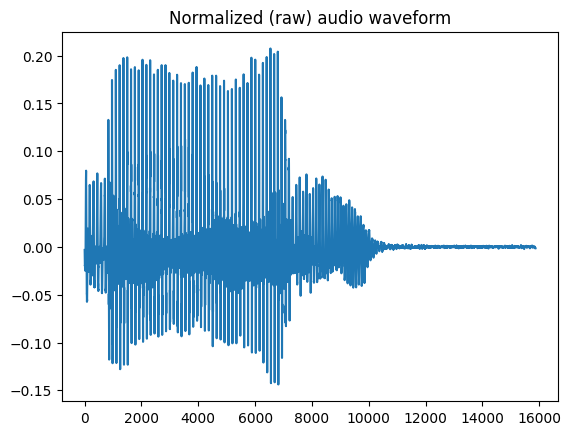

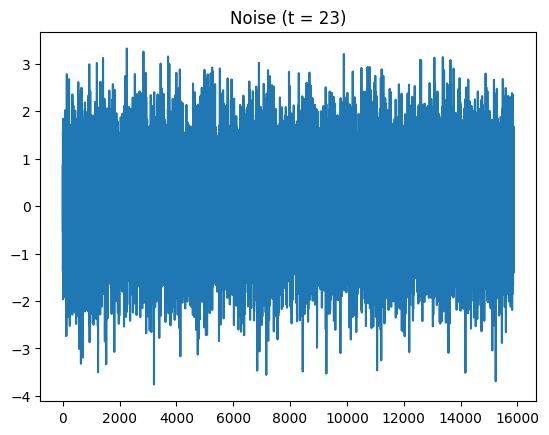

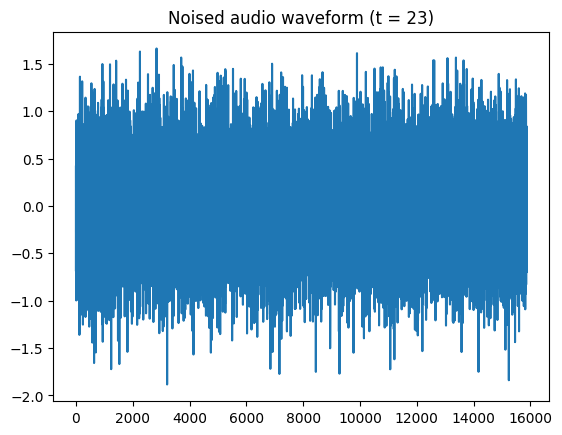

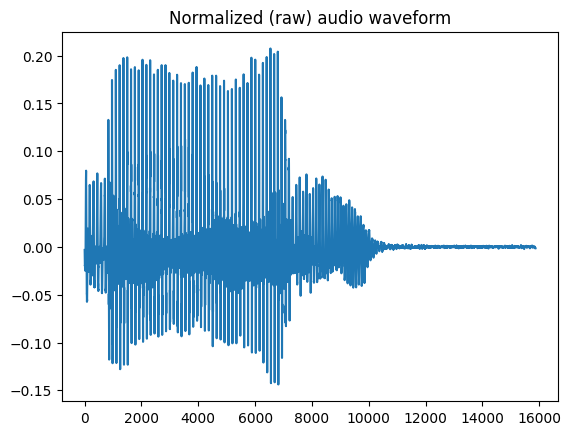

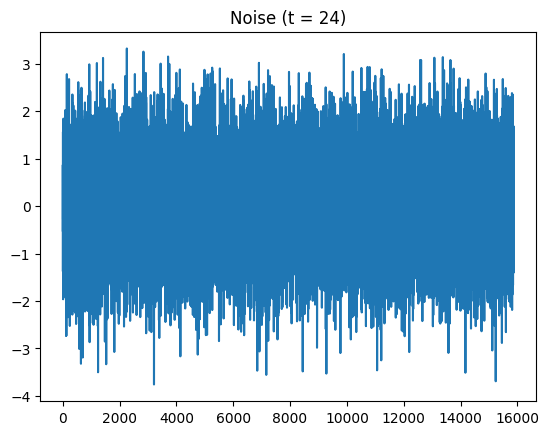

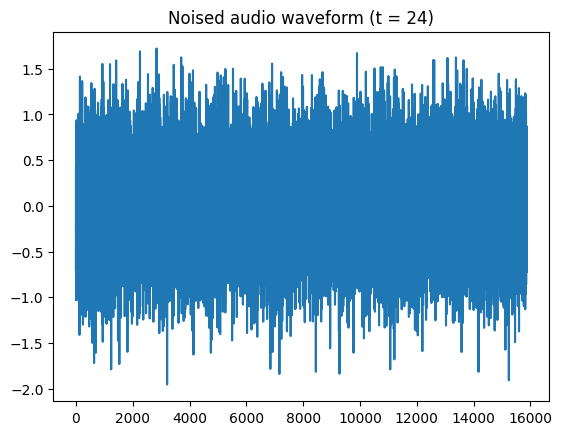

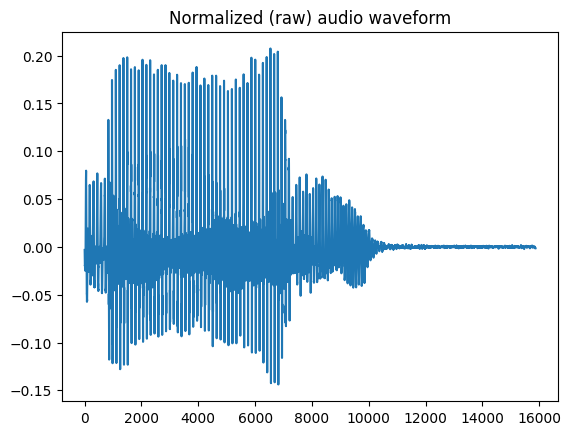

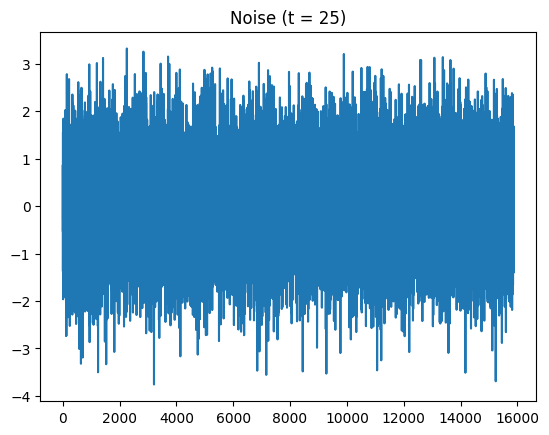

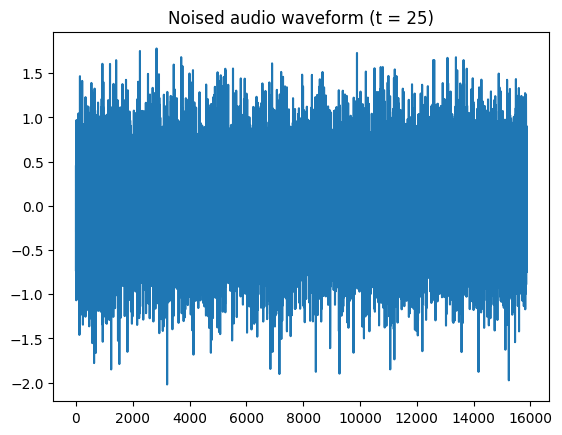

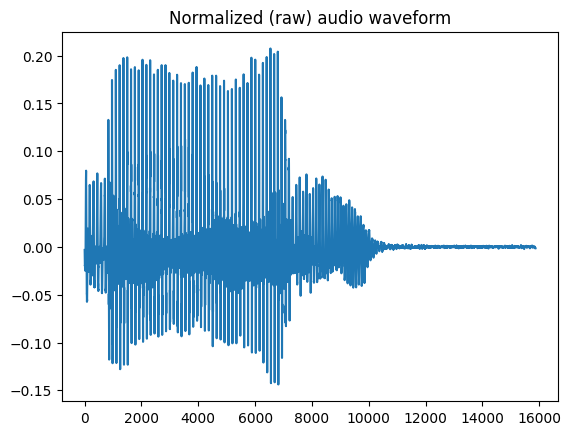

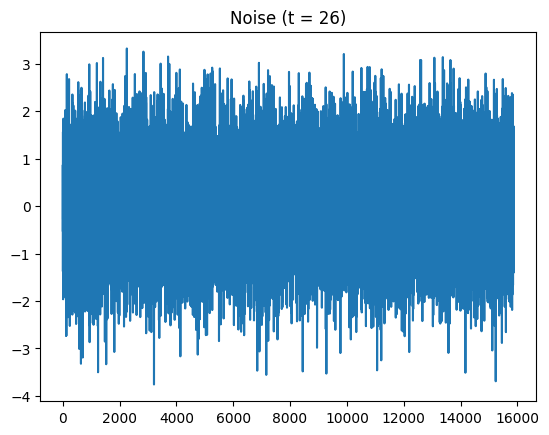

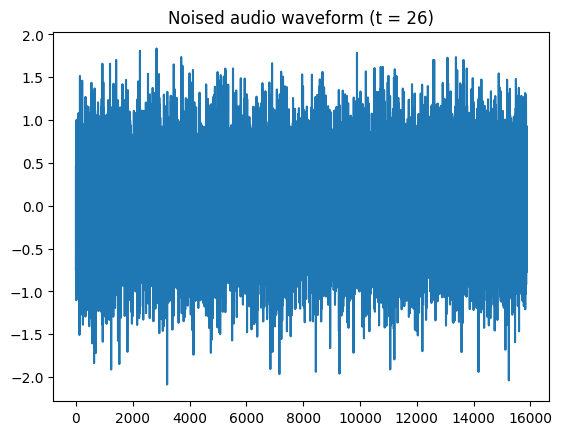

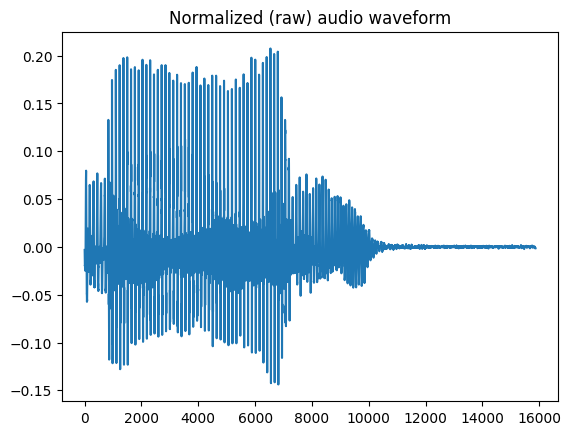

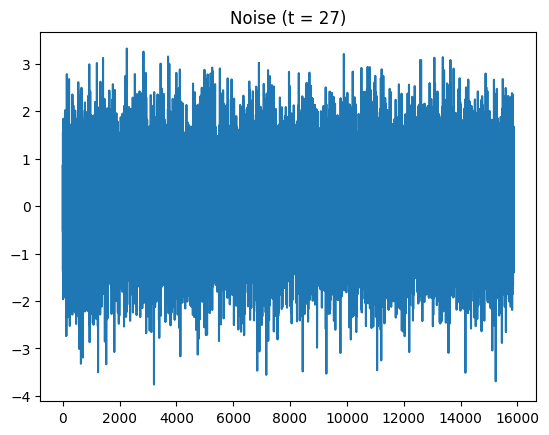

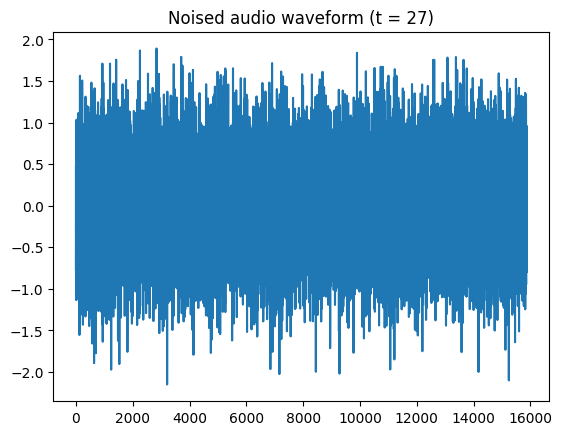

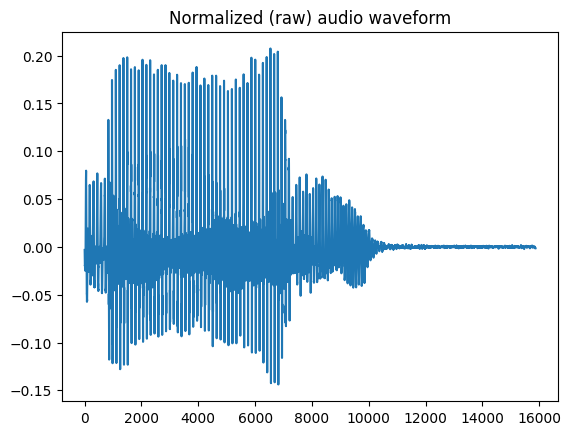

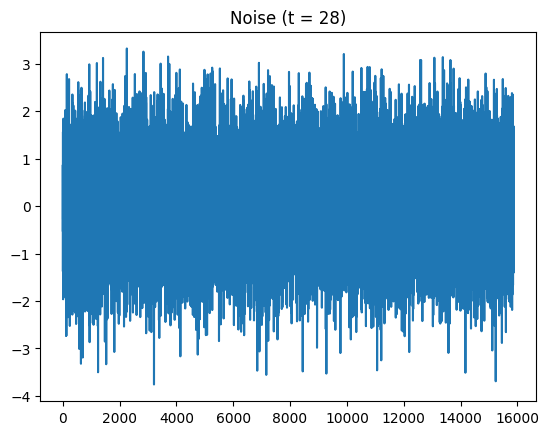

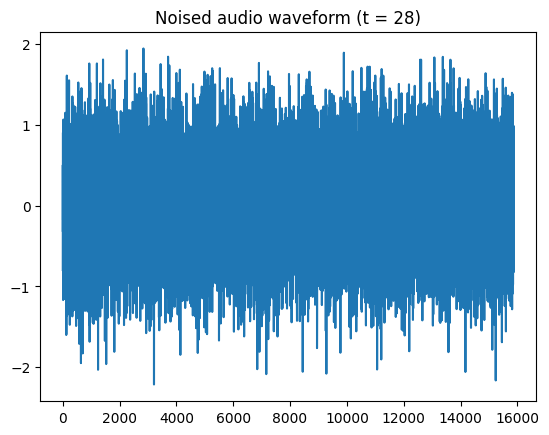

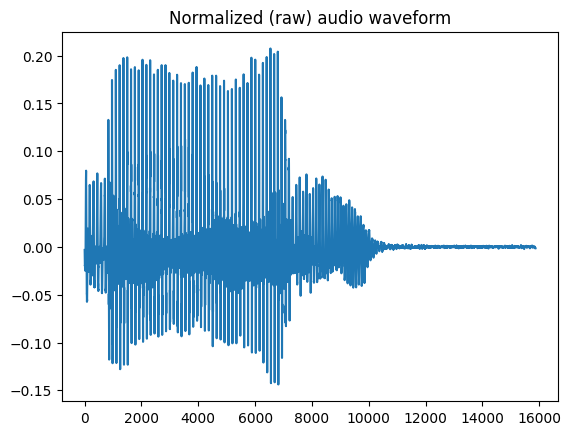

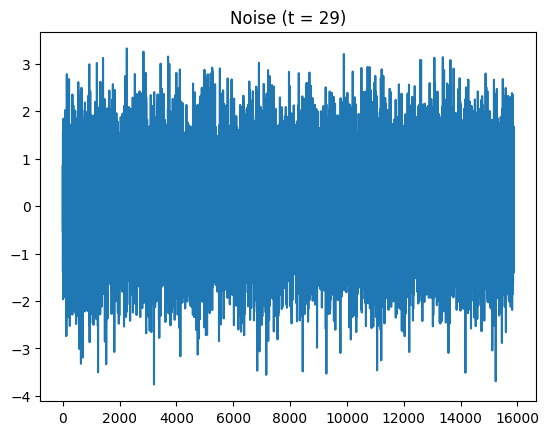

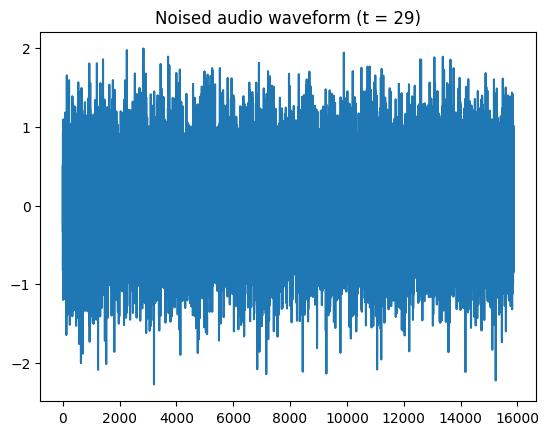

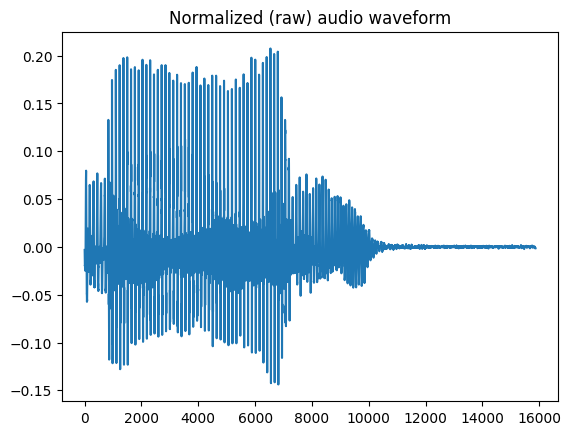

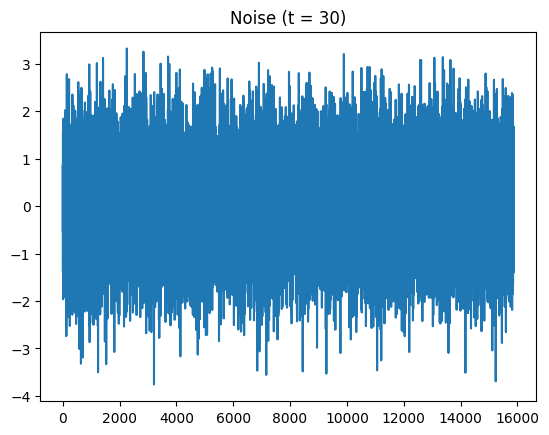

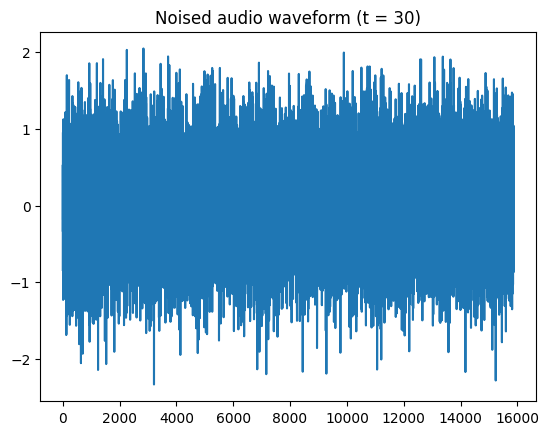

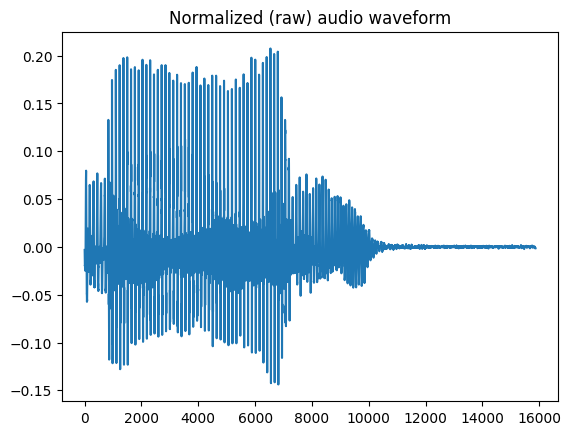

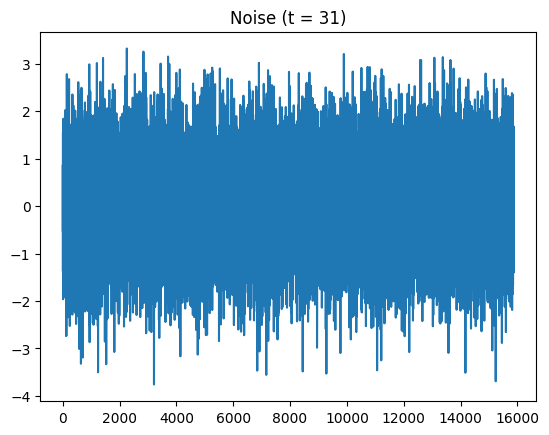

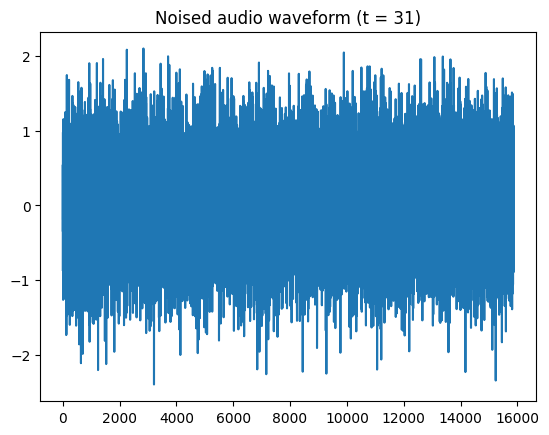

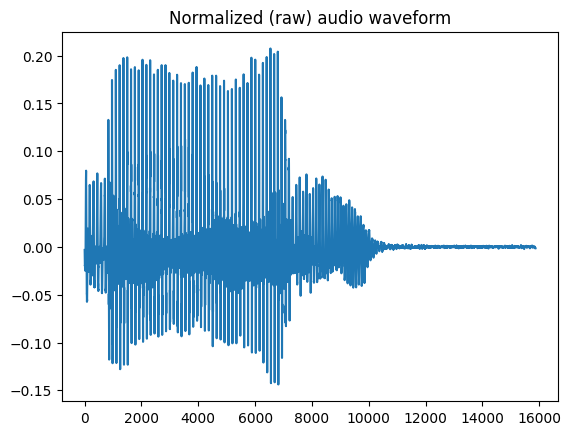

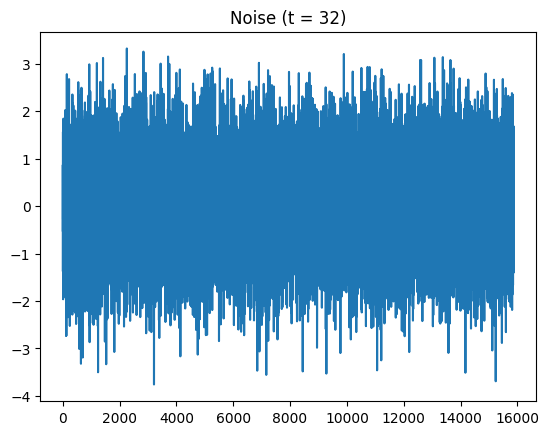

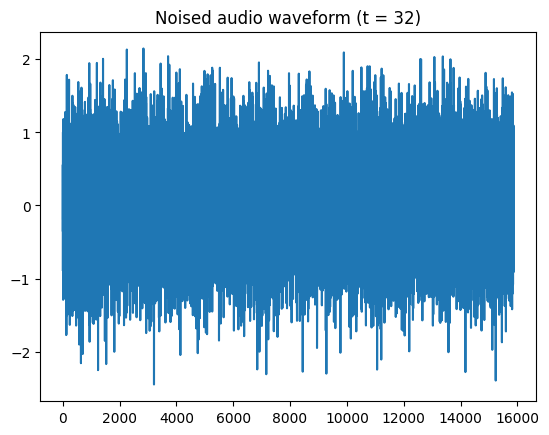

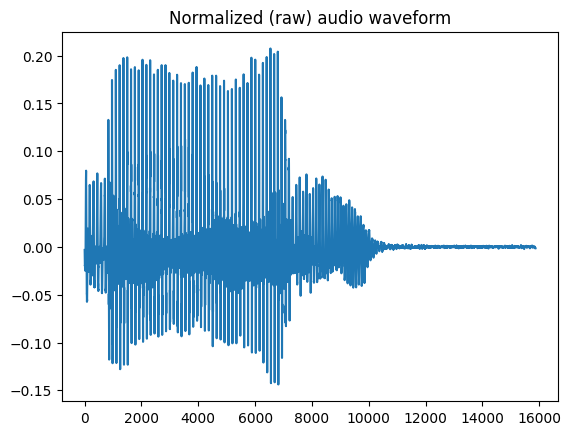

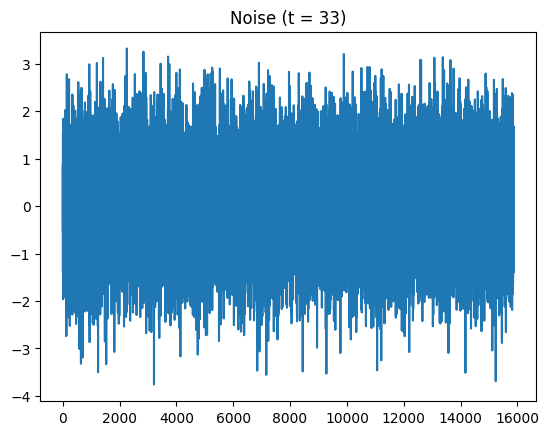

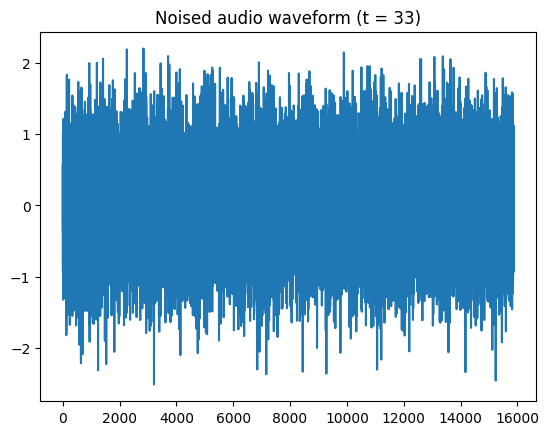

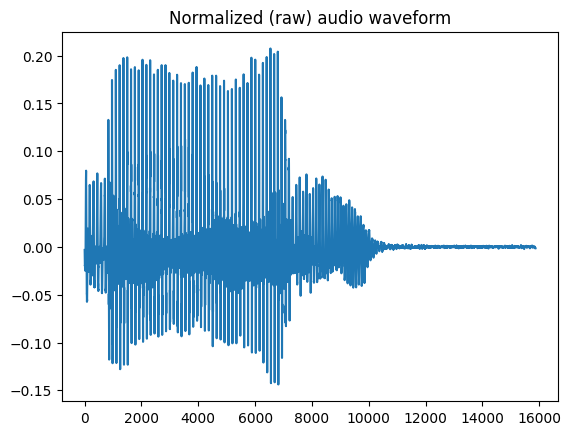

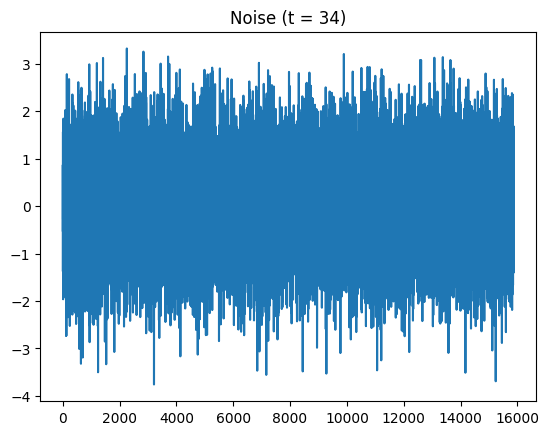

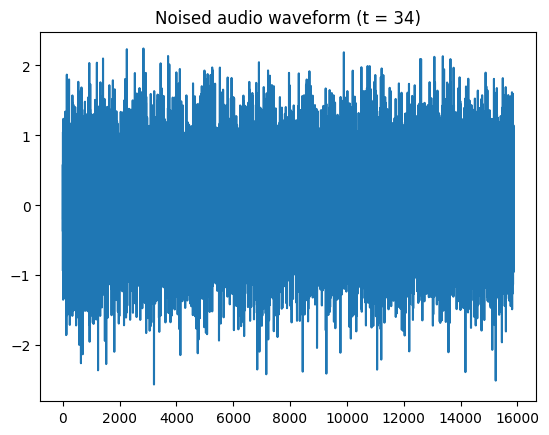

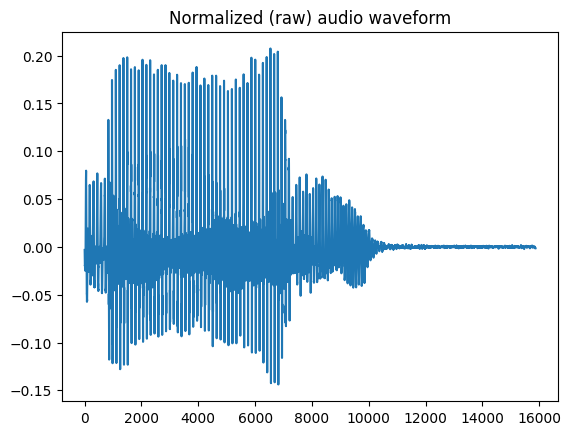

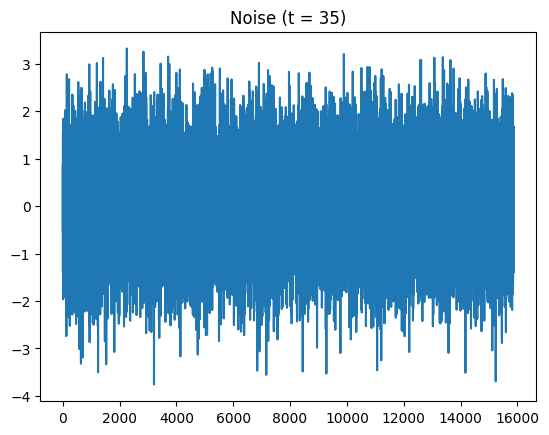

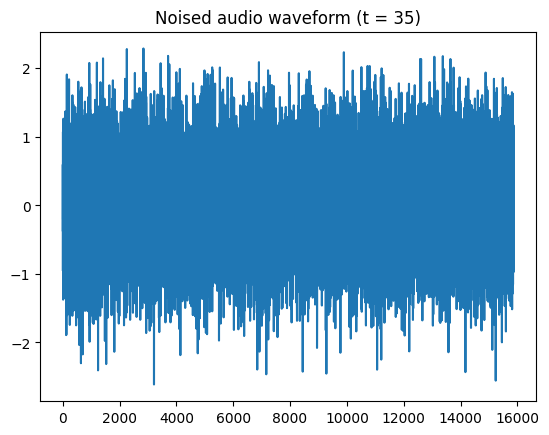

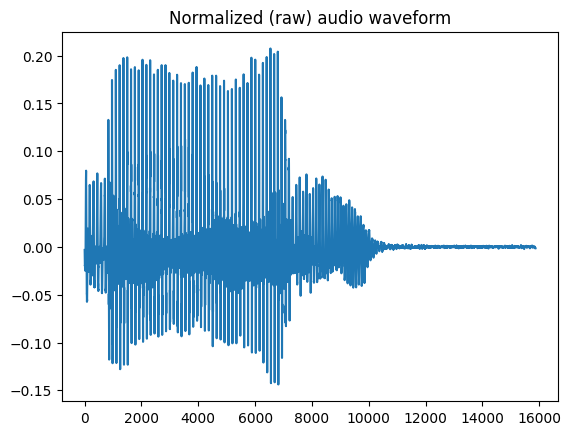

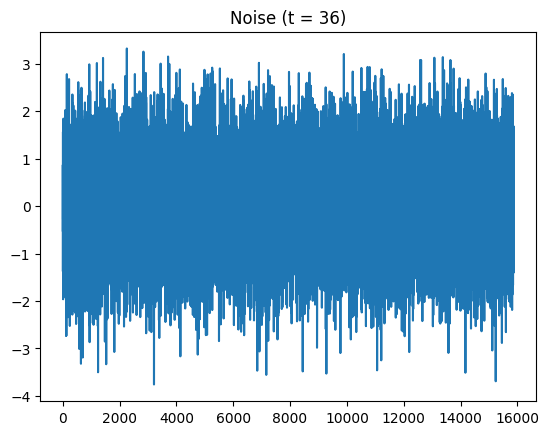

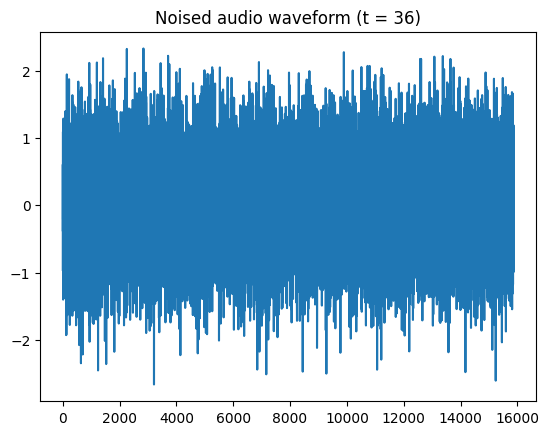

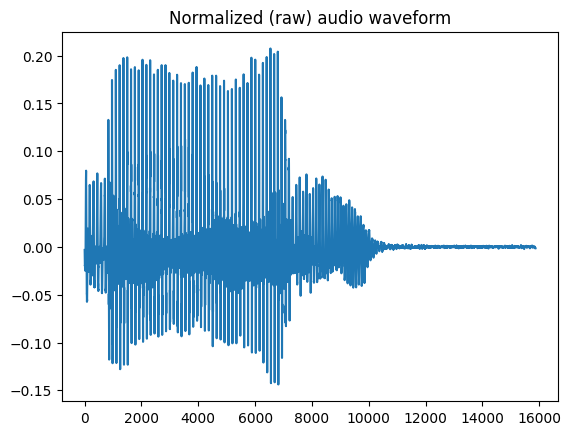

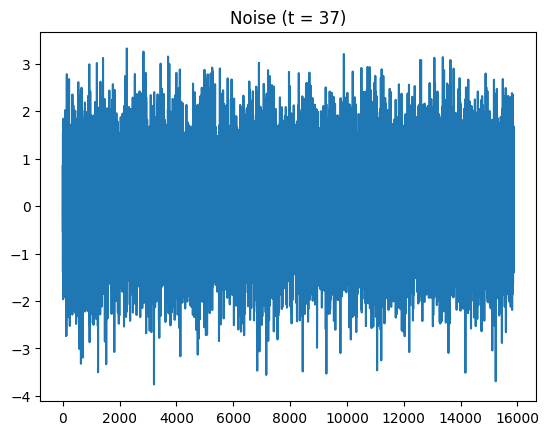

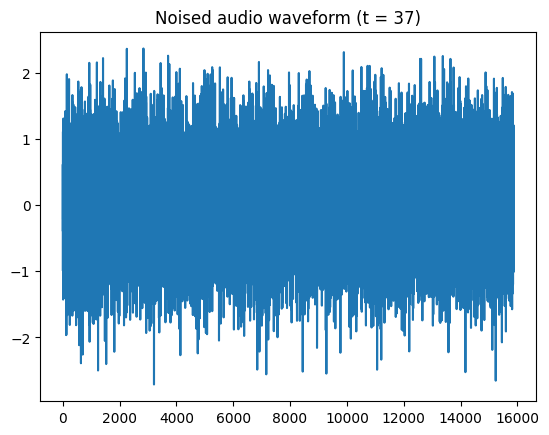

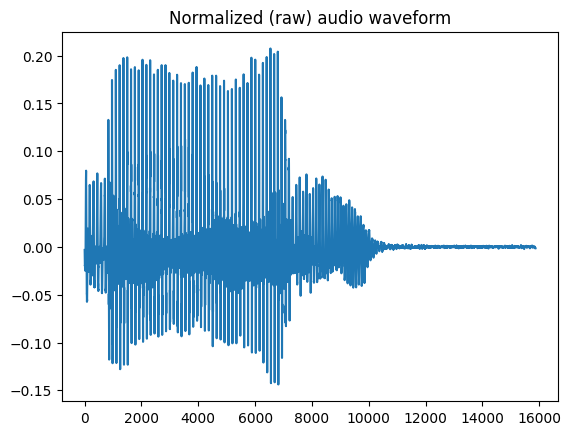

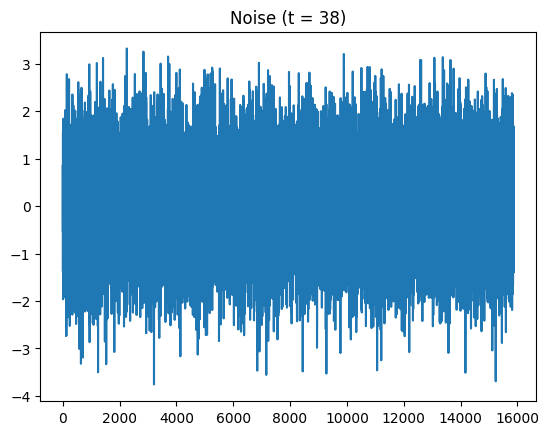

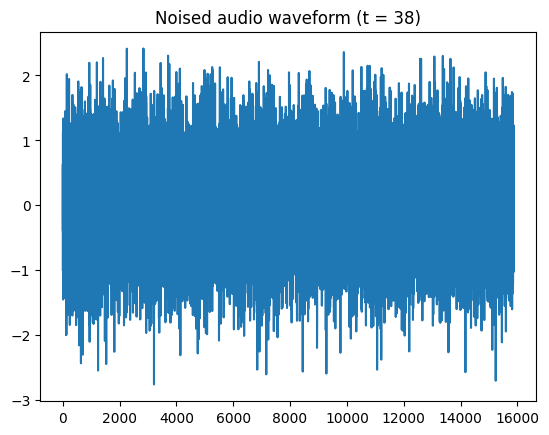

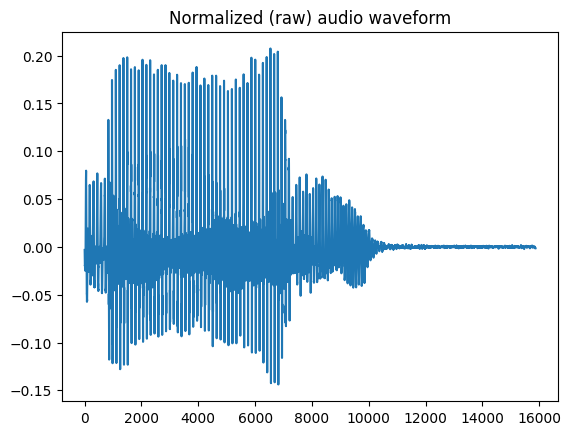

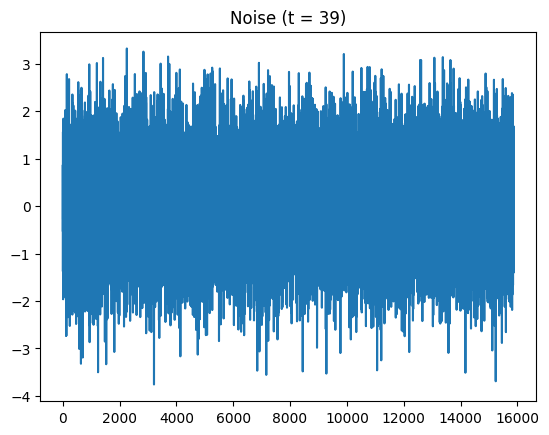

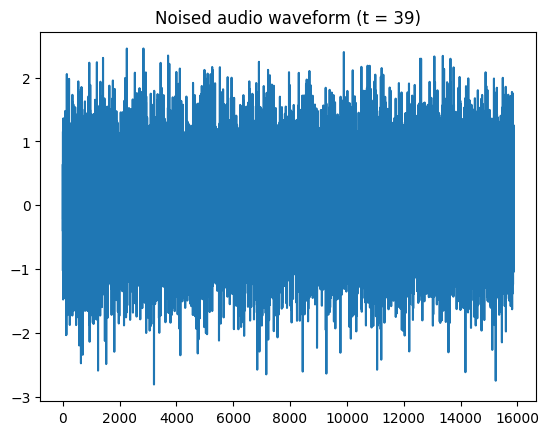

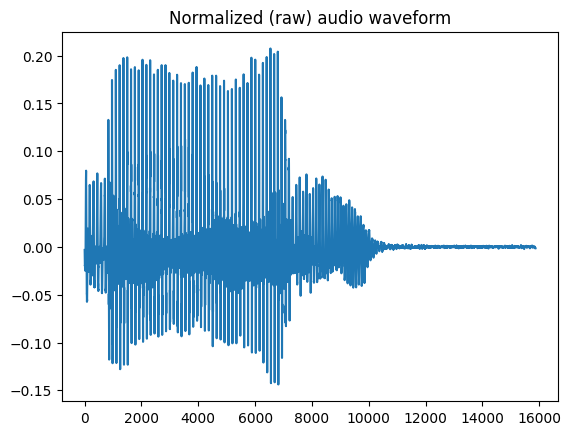

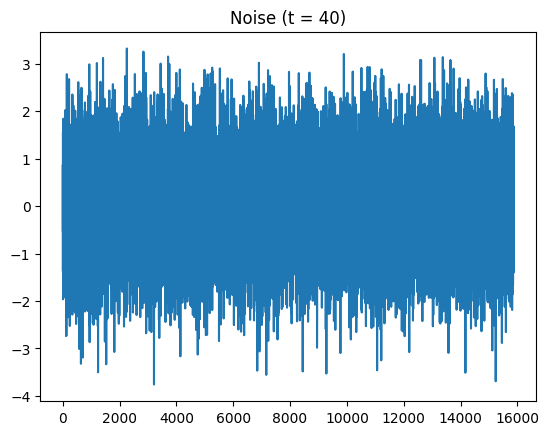

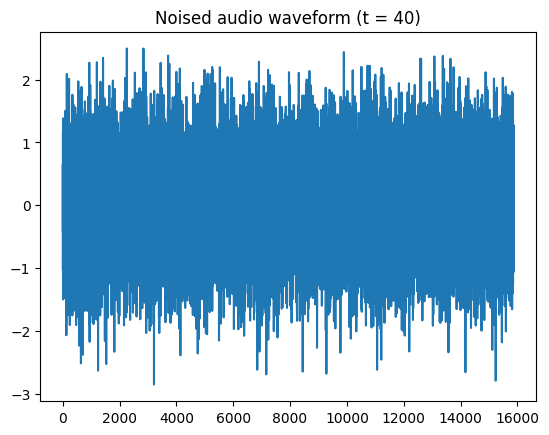

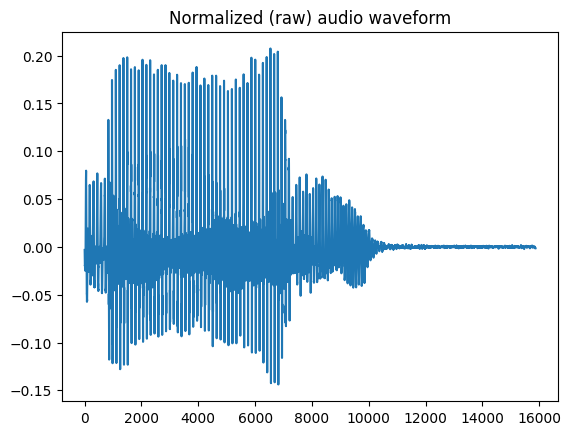

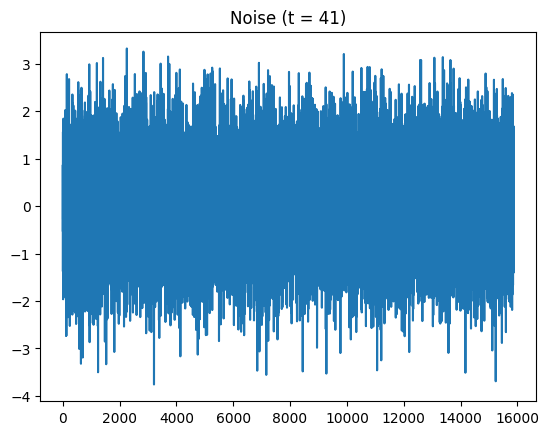

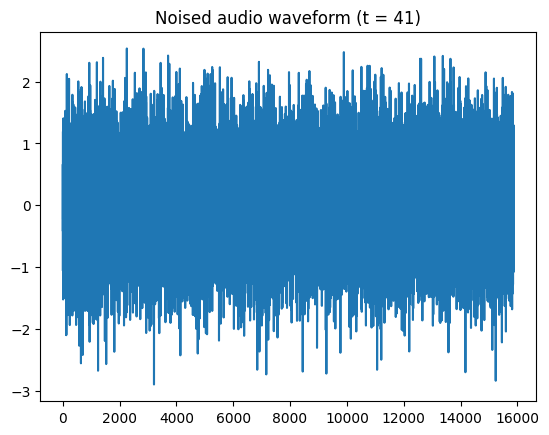

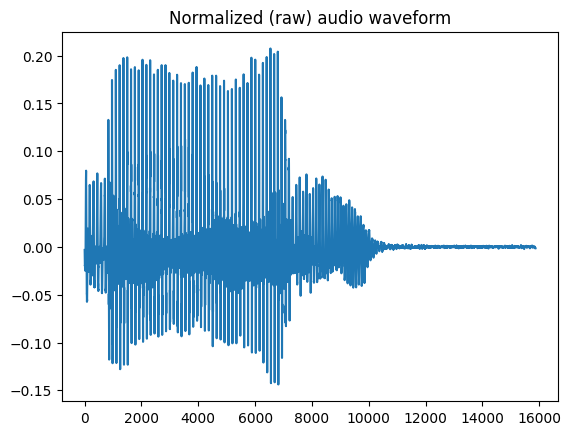

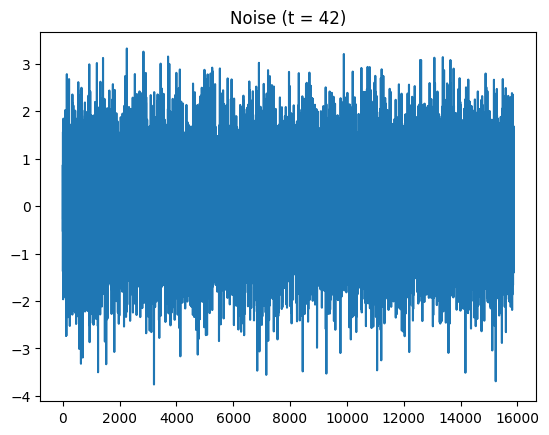

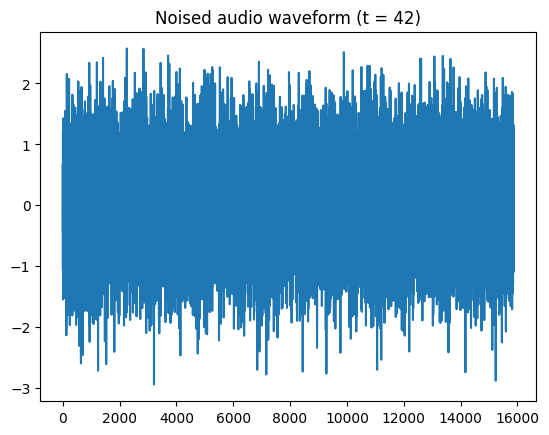

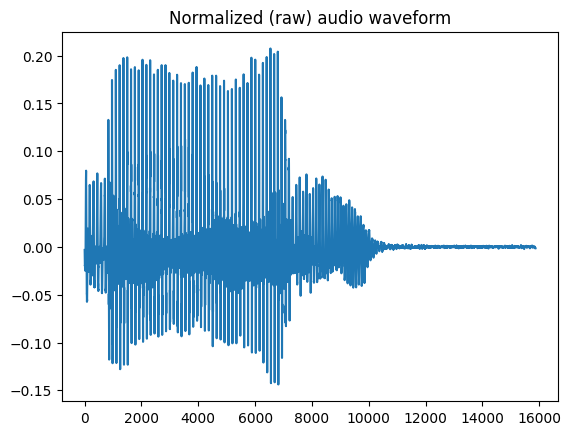

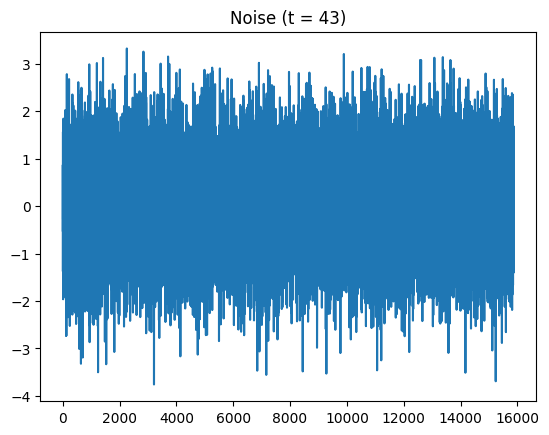

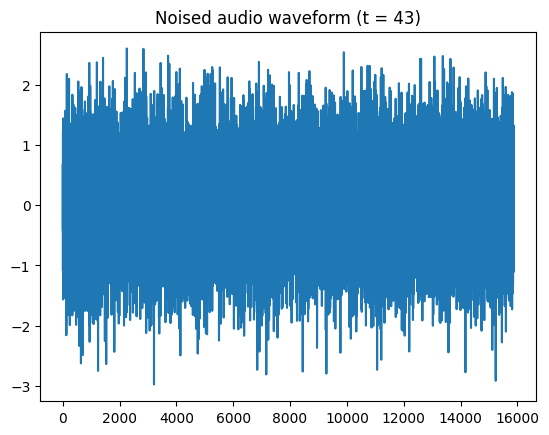

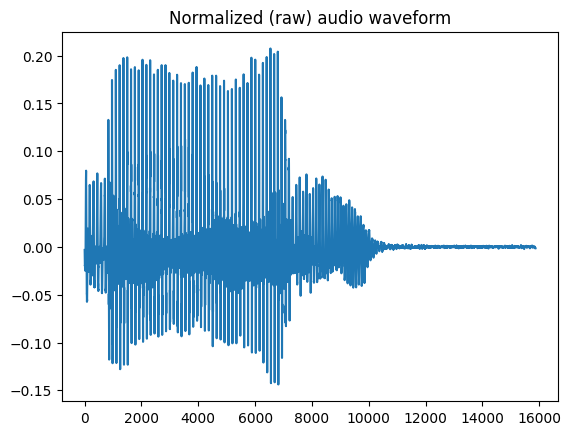

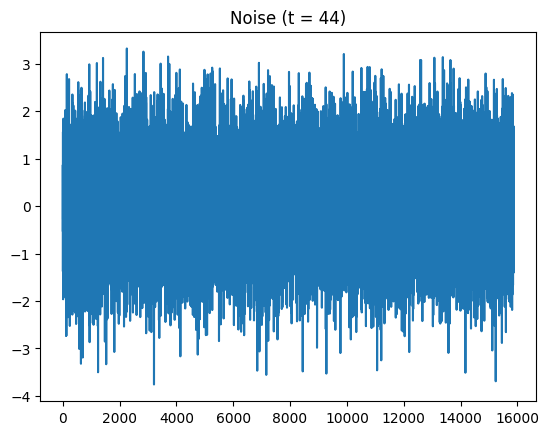

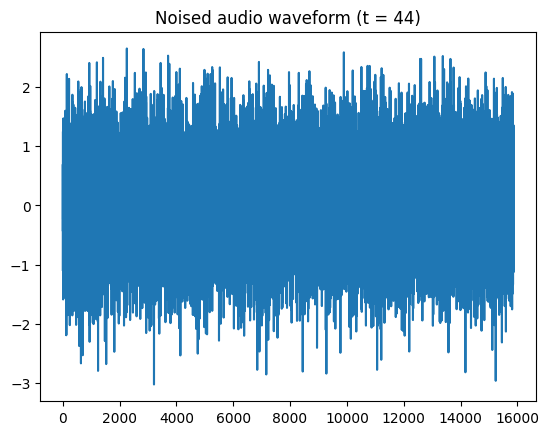

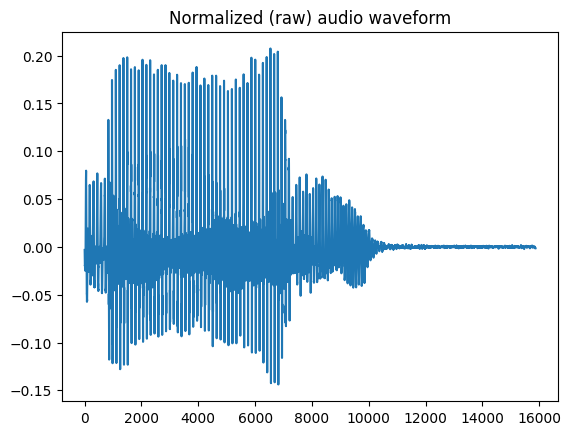

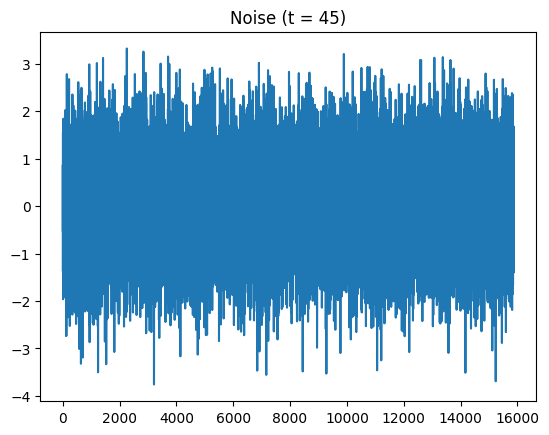

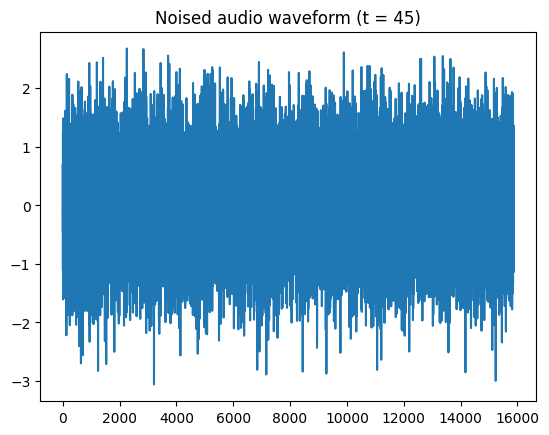

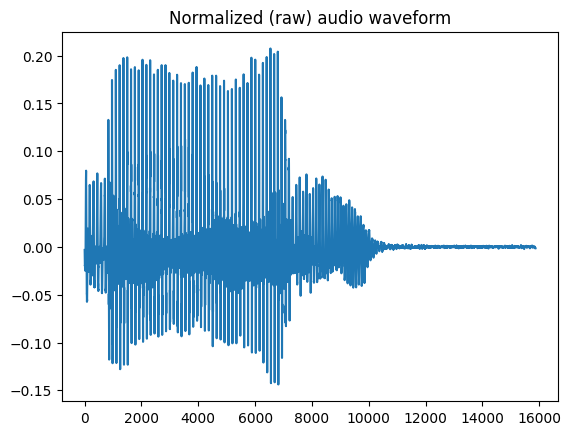

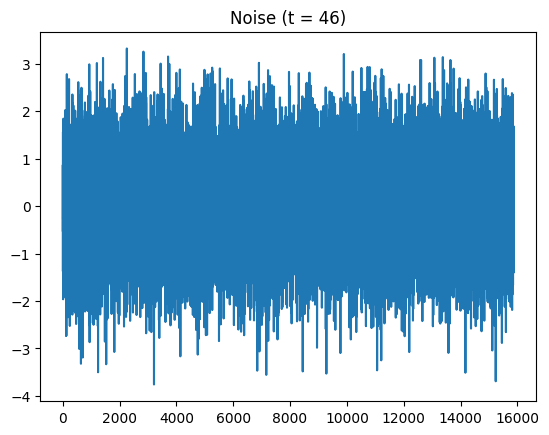

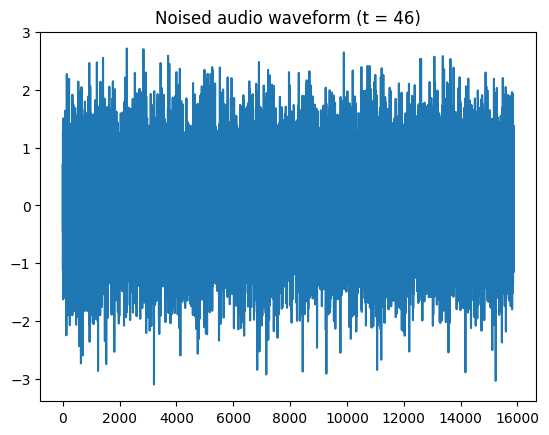

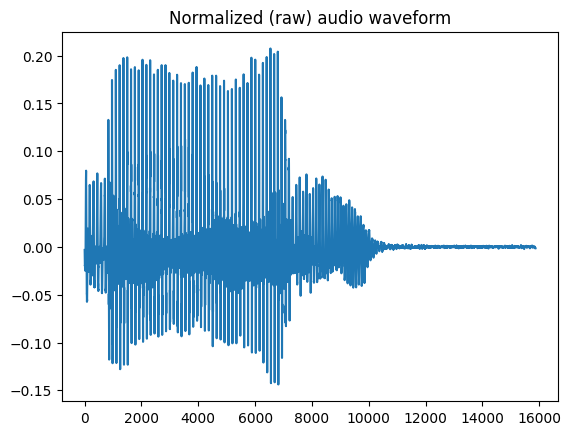

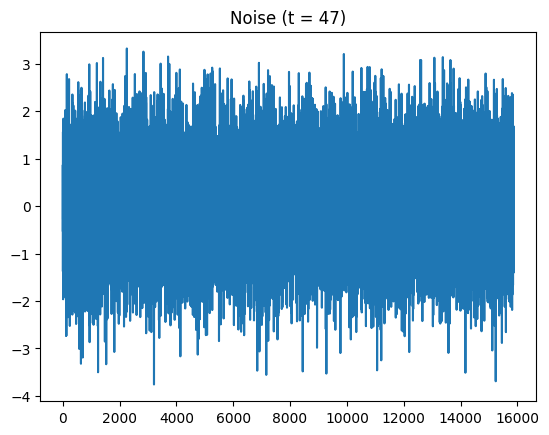

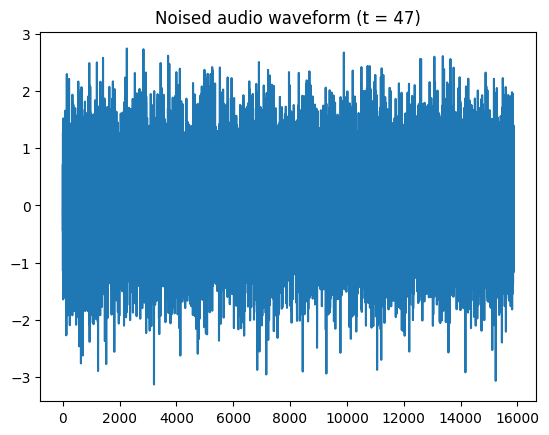

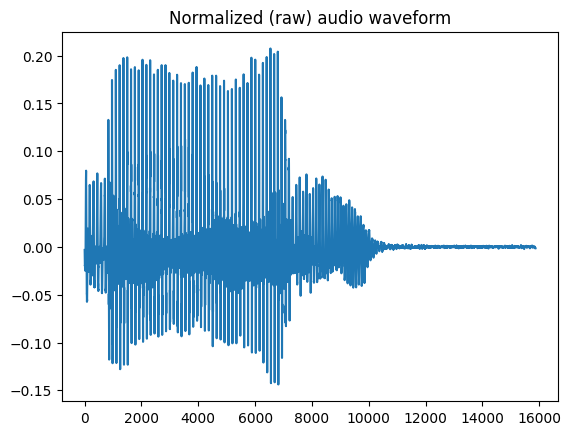

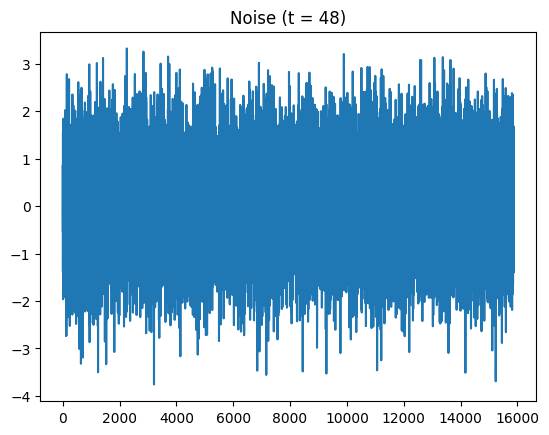

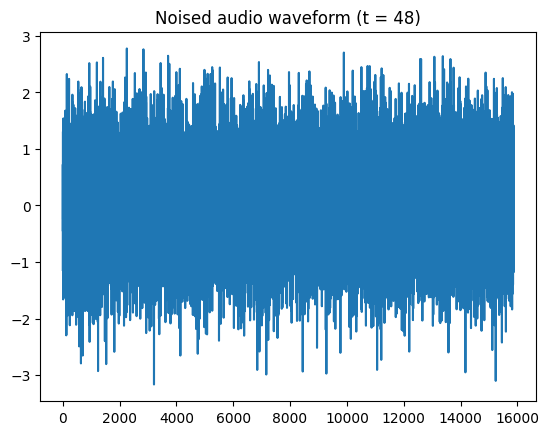

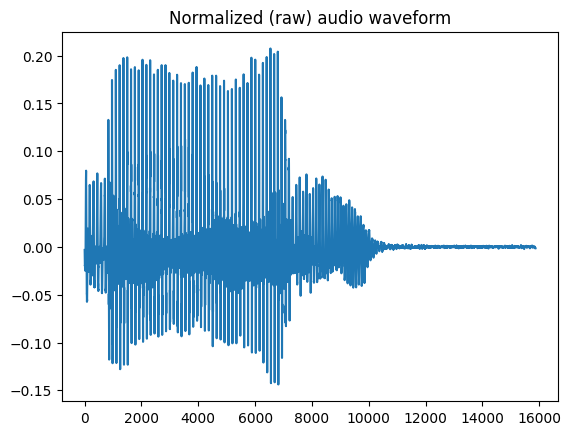

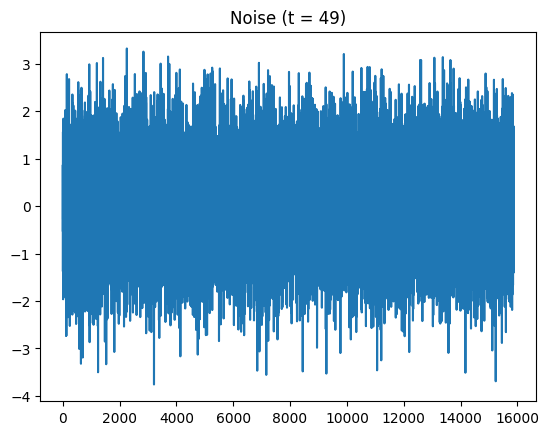

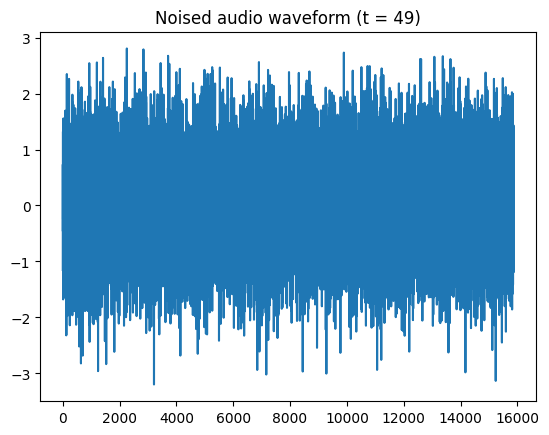

In [15]:
# Chart the noising steps

# Single audio sample.
audio_sample = tf.convert_to_tensor(audio[0], dtype=tf.float32)
# print(tf.shape(audio_sample))

for t in range(len(params.noise_schedule)):
    print(f'Timestep {t + 1}\n')

    # Apply noise to audio sample.
    noise_scale = tf.convert_to_tensor([noise_level[t]], dtype=tf.float32)
    # noise_scale = tf.expand_dims(noise_level[t], 1)
    # noise_scale = tf.cast(noise_scale, dtype=tf.float32)
    print(f'noise_scale {noise_scale}\n')

    noise_scale_sqrt = noise_scale ** 0.5
    print(f'noise_scale_sqrt {noise_scale_sqrt}\n')

    noise = tf.random.normal(tf.shape(audio_sample), dtype=tf.float32)
    print(f'noise {noise}\n')

    noisy_audio = noise_scale_sqrt * audio_sample + (1.0 - noise_scale) ** 0.5 * noise
    print(f'noisy_audio {noisy_audio}\n')

    print(f'audio_sample {audio_sample}\n')

    print('-' * 72)

    # Plot audio sample and noise to confirm gaussian distribution.
    plt.figure()
    plt.title(f'Normalized (raw) audio waveform')
    plt.plot(audio_sample)

    plt.figure()
    plt.title(f'Noise (t = {t})')
    plt.plot(noise)

    plt.figure()
    plt.title(f'Noised audio waveform (t = {t})')
    plt.plot(noisy_audio)
    